# Predicine/Moffitt Collaboration on Upper Tract Urothelial Cancer
## urine analyses

### Billie Gould

In [ ]:
library(ggplot2)
library(maftools)
library(readxl)
library(openxlsx)
library(tidyverse)
library(ComplexHeatmap)
library(circlize)
library(RColorBrewer)

files = system("ls ~/Desktop/puffin/R/*.R",intern = T)
for (f in files){ source(f)}

print(Sys.time())
print(sessionInfo())

In [ ]:
extract_counts <- function(df_variants, df_samples_){
    df_var_selected = df_variants %>% filter(SampleID.short %in% df_samples_$SampleID.short)
    df_counts = df_var_selected %>% group_by(SampleID.short) %>% 
        # summarize(n_variants=n(), max_MAF=max(VariantFreq)) %>%
        summarize(n_variants=n()) %>%
        right_join(df_samples_ %>% select(SampleID.short, PatientID, SampleType, StudyVisit, Stage), by="SampleID.short")
    df_counts$n_variants[is.na(df_counts$n_variants)] <- 0 #one count per reqid
    df_counts = df_counts %>% filter(PatientID!="UTUC-026")
    return(df_counts)
}

## read in data

In [ ]:
clinFile = "./ct.utDNA In UTUC Participants Shared with Predicine MCC20891 10.19.22_Latest_merged.csv"
df_clinical_updated = read.csv(clinFile, header=T, as.is=T) %>% slice_head(n=32)

names(df_clinical_updated) <- make.names(names(df_clinical_updated))
df_clinical_updated = df_clinical_updated %>% rename("PatientID"="Patient.Subject.ID.Number")

df_clinical_updated$Stage.bool = ifelse(is.na(df_clinical_updated$Muscle.invasive.or.Non.organ.confined),FALSE, TRUE)
df_clinical_updated$uro.recurence.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Urothelial"),TRUE,FALSE)
df_clinical_updated$metastisis.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Metastasis"),TRUE,FALSE)
df_clinical_updated$recur.or.metastisis.bool = (df_clinical_updated$uro.recurence.bool | df_clinical_updated$metastisis.bool)

df_clinical_updated$Stage = as.factor(ifelse(is.na(df_clinical_updated$Muscle.invasive.or.Non.organ.confined),"NMI","MI/NOC"))
df_clinical_updated$Tumor.architecture[is.na(df_clinical_updated$Tumor.architecture)] <- "Unknown"
df_clinical_updated$Clinical.T.Staging.byT2 = factor(gsub("TX",0, gsub("T1|Ta|T0|Tis|PUNLAP", 1, gsub("T2|T3|T4", 2, df_clinical_updated$Clinical.T.Staging))))
df_clinical_updated$Clinical.T.Staging.byT2[df_clinical_updated$Clinical.N.Staging == "N1"] <- 2 # NX considered missing data. 

# replace one missing age value with the mean
df_clinical_updated$Age.at.Surgery = ifelse(is.na(df_clinical_updated$Age.at.Surgery), mean(df_clinical_updated$Age.at.Surgery), df_clinical_updated$Age.at.Surgery)

df_clinical_updated$Pathologic.T.Staging[df_clinical_updated$Pathologic.T.Staging==""] <- "Undet."
df_clinical_updated$Pathologic.N.Staging[df_clinical_updated$Pathologic.N.Staging==""] <- "Undet."
df_clinical_updated$Pathologic.Grade[df_clinical_updated$Pathologic.Grade==""] <- "Undet."

# #shorten stage annotations
df_clinical_updated$Pathologic.N.Staging[df_clinical_updated$Pathologic.N.Staging=="N1 (Single Node < 2cm)"] <- "N1"
df_clinical_updated$Pathologic.N.Staging[df_clinical_updated$Pathologic.N.Staging=="N2 (Single Node 2-5 cm, Multiple Nodes < 2cm)"] <- "N2"
df_clinical_updated$Pathologic.N.Staging[df_clinical_updated$Pathologic.N.Staging=="NO"] <- "N0"

# # order samples by NMI/MI stage, path T stage, and N stage
df_clinical_updated$Pathologic.T.Staging[grepl("PUNLAP|Tis|TA",df_clinical_updated$Pathologic.T.Staging)] <- "PUNLAP/Tis/TA"
df_clinical_updated = df_clinical_updated %>% arrange(factor(Stage, levels=c("early","late")),
                                                factor(Pathologic.T.Staging, levels=c("Undet.","PUNLAP/Tis/TA","T1","T2","T3","T4")),
                                                factor(Pathologic.N.Staging, levels=c("Undet.","NX","N0","N1","N2")),
                                                PatientID) %>% 
                                        mutate(Stage=ifelse(Stage=="early","NMI","MI/NOC"))

df_clinical_updated = df_clinical_updated[!duplicated(df_clinical_updated$PatientID),]
df_clinical_updated$PatientID
# names(df_clinical)

In [ ]:
# load excel edited sample list
df_libraries = read.xlsx("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_panel_lpwgs_qc_merged.xlsx",
                         sheet="Batch1_Batch7_PRDC-MOFFITT-UTUC")
df_libraries = df_libraries %>% slice_head(n=230) %>% filter(as.character(finalKeep)=="TRUE")  # this removes 026 among others

df_libraries$SampleID.short = sapply(str_split(df_libraries$SampleID, "A01"),"[",1)
df_libraries$SampleType = trimws(tolower(df_libraries$SampleType))

df_libraries$StudyVisit = tolower(gsub("Pre-Op|PreOP1|PreOp|Preop|PreOp1|pre_op1", "pre_op", df_libraries$StudyVisit))
df_libraries$StudyVisit[df_libraries$SampleType=="ffpe"] <- "pre_op" # some FFPE are N/A
# df_libraries$StudyVisit = factor(df_libraries$StudyVisit, levels = c("pre_op","postop1","postop2","postop3","postop4",
#                                                                      "followup1","followup2","followup3","followup4", NA))
df_libraries$StudyVisit <- factor(gsub("followup1", "postop1", 
                                 gsub("followup2", "postop2",
                                      gsub("followup3", "postop3", 
                                           gsub("followup4", "postop4", df_libraries$StudyVisit)))),
                                   levels=c("pre_op","postop1","postop2","postop3","postop4"))
                                           

df_libraries = df_libraries %>% left_join(df_clinical %>% select(PatientID, Stage), by="PatientID")

# add updated plasma/ffpe/urine tumor fraction and TMB
df_qc_update_plas = read.csv("./completed_plus_followups/plasma_data_refiltered/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_NGSQC_plasma_2022-07-25_updated.csv", as.is=T)
df_qc_update_plas = df_qc_update_plas %>% mutate(SampleID.short=make_SIDshort(SampleID)) %>% 
        rename("pTMB.norm.weighted.updated"=pTMB_norm.weighted,
               "tumorFraction.updated"=tumorFraction,
               "maxAF_TMB.updated"=maxAF_TMB) %>% 
        select(SampleID.short, SampleID, pTMB.norm.weighted.updated,tumorFraction.updated, maxAF_TMB.updated)
df_qc_update_ffpe = read.csv("./completed_plus_followups/ffpe_data_refiltered/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_NGSQC_ffpe_2022-07-25_updated.csv",as.is=T)
df_qc_update_ffpe = df_qc_update_ffpe %>% mutate(SampleID.short=make_SIDshort(SampleID)) %>% 
        rename("pTMB.norm.weighted.updated"=pTMB_norm.weighted,
               "tumorFraction.updated"=tumorFraction,
               "maxAF_TMB.updated"=maxAF_TMB) %>% 
        select(SampleID.short, SampleID, pTMB.norm.weighted.updated,tumorFraction.updated, maxAF_TMB.updated)
df_qc_update_urine = read.csv("./completed_plus_followups/urine_data_refiltered/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_NGSQC_urine_2022-07-25_updated.csv", as.is=T)
df_qc_update_urine = df_qc_update_urine %>% mutate(SampleID.short=make_SIDshort(SampleID)) %>% 
        rename("pTMB.norm.weighted.updated"=pTMB_norm.weighted,
               "tumorFraction.updated"=tumorFraction,
               "maxAF_TMB.updated"=maxAF_TMB) %>% 
        select(SampleID.short, SampleID, pTMB.norm.weighted.updated,tumorFraction.updated, maxAF_TMB.updated)
df_updated = rbind(df_qc_update_plas, df_qc_update_ffpe, df_qc_update_urine)
df_libraries = df_libraries %>% left_join(df_updated, by=c("SampleID.short"))
nrow(df_libraries)

###
df_buffy = df_libraries %>% filter(SampleType=="buffy coat", QC_Status.panel %in% c("Pass","At risk")) #exclude Fail and NA
print(sprintf("buffy coat: %s", nrow(df_buffy)))

df_plasma = df_libraries %>% filter(grepl("plasma", SampleType, ignore.case=T))
df_plasma_preop = df_plasma %>% filter(StudyVisit=="pre_op")
      print(sprintf("plasma preop CARE %s", nrow(df_plasma_preop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))
      print(sprintf("plasma preop lpwgs %s", nrow(df_plasma_preop %>% filter(qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk")))))
df_plasma_postop = df_plasma %>% filter(StudyVisit!="pre_op")
      print(sprintf("plasma postop CARE %s", nrow(df_plasma_postop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))
      print(sprintf("plasma postop lpwgs %s", nrow(df_plasma_postop %>% filter((qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))))))

df_urine = df_libraries %>% filter(grepl("Urine", SampleType, ignore.case=T))
df_urine_preop = df_urine %>% filter(StudyVisit=="pre_op")
      print(sprintf("urine preop CARE %s", nrow(df_urine_preop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))
      print(sprintf("urine preop lpwgs %s", nrow(df_urine_preop %>% filter((qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))))))
df_urine_postop = df_urine %>% filter(StudyVisit!="pre_op")
      print(sprintf("urine postop CARE %s", nrow(df_urine_postop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))
      print(sprintf("urine postop lpwgs %s", nrow(df_urine_postop %>% filter((qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))))))

df_ucp = df_libraries %>% filter(grepl("UCP", SampleType, ignore.case=T))
df_ucp_preop = df_ucp %>% filter(StudyVisit=="pre_op")
      print(sprintf("ucp preop CARE %s", nrow(df_ucp_preop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))
df_ucp_postop = df_ucp %>% filter(StudyVisit!="pre_op")
      print(sprintf("ucp postop CARE %s", nrow(df_ucp_postop %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T)))))

df_ffpe = df_libraries %>% filter(grepl("FFPE", SampleType, ignore.case=T)) 
df_ffpe_care = df_ffpe %>% filter(grepl("Pass|At risk|Pass_0.5", QC_Status.panel, ignore.case=T))
    print(sprintf("ffpe care %s", nrow(df_ffpe_care)))
df_ffpe_lpwgs = df_ffpe %>% filter(qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))
    print(sprintf("ffpe lpwgs %s", nrow(df_ffpe_lpwgs)))

# define preop care samples to use
df_plasma_preop_care = df_plasma_preop %>% filter(grepl("Pass|At risk", QC_Status.panel, ignore.case=T))
df_urine_preop_care = df_urine_preop %>% filter(grepl("Pass|At risk", QC_Status.panel, ignore.case=T))
df_ucp_preop_care = df_ucp_preop %>% filter(grepl("Pass|At risk", QC_Status.panel, ignore.case=T))

## paired sample sets:

# FFPE Plasma Pairs
df_ffpe_preplasma_care = rbind(df_ffpe_care, df_plasma_preop_care) %>% filter(PatientID %in% df_ffpe_care$PatientID, 
                                                                         PatientID %in% df_plasma_preop_care$PatientID)
nrow(df_ffpe_preplasma_care) # missing UTUC-015 and UTUC-026

# urine/ffpe Pairs
df_ffpe_preurine_care = rbind(df_ffpe_care, df_urine_preop_care) %>% filter(PatientID %in% df_ffpe_care$PatientID, 
                                                                         PatientID %in% df_urine_preop_care$PatientID)
nrow(df_ffpe_preurine_care)

#Plasma/Urine preop Pairs
df_preplasma_preurine_care = rbind(df_plasma_preop_care, df_urine_preop_care) %>% filter(PatientID %in% df_plasma_preop_care$PatientID, 
                                                                         PatientID %in% df_urine_preop_care$PatientID)
nrow(df_preplasma_preurine_care)  # unpaired due to lack of plasma are 019 and 015

# Urine/UCP preop pairs
df_preucp_preurine_care = rbind(df_urine_preop_care, df_ucp_preop_care) %>% filter(PatientID %in% df_urine_preop_care$PatientID, 
                                                                         PatientID %in% df_ucp_preop_care$PatientID)
nrow(df_preucp_preurine_care)

# ucp/ffpe Pairs
df_ffpe_preucp_care = rbind(df_ffpe_care, df_ucp_preop_care) %>% filter(PatientID %in% df_ffpe_care$PatientID, 
                                                                         PatientID %in% df_ucp_preop_care$PatientID)
nrow(df_ffpe_preucp_care)

In [ ]:
plot(df_urine_preop_care$tumorFraction, df_urine_preop_care$tumorFraction.updated) #check that one outlier
plot(df_urine_preop_care$pTMB_norm.weighted, df_urine_preop_care$pTMB.norm.weighted.updated) #use updated
plot(df_urine_preop_care$maxAF_TMB,df_urine_preop_care$maxAF_TMB.updated) #use updated

In [265]:
# load variants  ## kelu will rerun all variant calling on DS 1.7.1 by mid june. rerun post-analysis on these data
# currently some pipeline 1.6.2 data was already rerun wiht 1.7.1 and original data is missing. See chat with Kelu

source("~/Desktop/puffin/R/format_as_MAF.R")

df_libraries$StudyVisit = as.character(df_libraries$StudyVisit)

#internal UNpatched data set
all.snv_internal_no_patch_ = read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_Variant_short_all_2022-07-25_ffpe_plasma_urine_ucp_marked.csv",
                            header=TRUE, stringsAsFactors=FALSE)
all.snv_internal_no_patch = format_as_MAF(all.snv_internal_no_patch_, sid.format="strict", 
                                         variant.type="snv", maf.output=FALSE, df_samples=df_libraries) %>%
                                filter(!is.na(Hugo_Symbol))
# filter pathogenic snvs
all.snv_nopatch_path = all.snv_internal_no_patch %>% 
    filter(grepl("pathogen", CLIN_SIG, ignore.case=T) | grepl("pathogen", Clinvar, ignore.case=T))

#load CNVs
all.file = "./completed_plus_followups/PRDC-MOFFITT-UTUCBC-21001_data_20220822.xlsx" # full external file (MAF formatted cols)
all.cnv_external = read.xlsx(all.file, sheet = "DNA_CNV")
all.cnv_external = format_as_MAF(all.cnv_external, sid.format="strict", 
                                     variant.type="cnv", maf.output=FALSE, df_samples=df_libraries) %>%
                                filter(!is.na(Hugo_Symbol))
nrow(all.cnv_external)

# combine all variants
all.var_internal_no_patch = rbind.common(all.snv_internal_no_patch, all.cnv_external) %>% 
                            filter(SampleID.short %in% df_libraries$SampleID.short, !is.na(Hugo_Symbol)) %>% distinct()
nrow(all.var_internal_no_patch)

# load internal patched data sets
# using ffpe as the reference data set ## note this file contains several manual bug fixes as changes to the germline/somatic call, see missing_variants_09062022.xlxs
all.snv_internal_ffpe_patch_ = read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_Variant_short_all_2022-07-25_marked_patched_ffpe_reviewed_BG_09132022.csv",
                            header=TRUE, stringsAsFactors=FALSE)
all.snv_internal_ffpe_patch = format_as_MAF(all.snv_internal_ffpe_patch_, sid.format="strict", 
                                     variant.type="snv", maf.output=FALSE, df_samples=df_libraries)
all.cnv_external$Patched = FALSE
cols = c("PatientID","SampleID.short","VariantID","Patched", "Hugo_Symbol","StudyVisit","SampleType")
all.var_internal_ffpe_patch = rbind.common(all.snv_internal_ffpe_patch, all.cnv_external) %>% 
                            filter(SampleID.short %in% df_libraries$SampleID.short, !is.na(Hugo_Symbol)) %>% distinct()

## check for missing variants in the patched set
all.snv_internal_no_patch = all.snv_internal_no_patch %>%
                            mutate("ID2"=paste(SampleID.short,VariantID, sep=":"))
all.snv_internal_ffpe_patch = all.snv_internal_ffpe_patch %>%
                            mutate("ID2"=paste(SampleID.short,VariantID, sep=":"))
all.snv_internal_ffpe_patch_ = all.snv_internal_ffpe_patch_ %>%
                            mutate("SampleID.short"=make_SIDshort(sampleNames),"ID2"=paste(SampleID.short,VariantID, sep=":"))
head(all.snv_internal_no_patch$ID2)
head(all.snv_internal_ffpe_patch$ID2)
head(all.snv_internal_ffpe_patch_$ID2)
if (any(all.snv_internal_no_patch$ID2 %!in% all.snv_internal_ffpe_patch$ID2)){
    print(all.snv_internal_no_patch$ID2[all.snv_internal_no_patch$ID2 %!in% all.snv_internal_ffpe_patch$ID2])
    df.missing = all.snv_internal_no_patch[(all.snv_internal_no_patch$ID2 %!in% all.snv_internal_ffpe_patch$ID2),]
    nrow(df.missing)

    out = rbind.common(standardize_names(df.missing %>% mutate(Set="Original.Set")),
                       standardize_names(all.snv_internal_ffpe_patch_ %>% mutate(Set="Patched.Set") %>% filter(ID2 %in% df.missing$ID2))) %>% 
              relocate(Set, PatientID, SampleID.short, SampleType, StudyVisit, ID2, finalKeep, VariantType) %>% arrange(ID2)

    write.csv(out,
         "./completed_plus_followups/missing_patched_SNVs.csv", row.names=F)
}
# rerun variant retireval and patching with .dist2end input files

[1] "SNV types present (selecting somatic):"
[1] "Germline"              "Somatic"               "Likely somatic"       
[4] "Likely germline"       "Likely CHIP mutations" "CHIP mutations"       
[1] "Selected snvs: 660"
[1] "Selected CNVs: 257"


[1] 257

[1] 917

[1] "TRUE"           NA               "highConfidence" "lowConfidence" 
[5] "FALSE"          "true"          
[1] "WARN: some variants finalKeep term unrecognized. Keeping these"
[1] "SNV types present (selecting somatic):"
[1] "Germline"              "Somatic"               "Likely germline"      
[4] "Likely somatic"        "Likely CHIP mutations" "CHIP mutations"       
[1] "Selected snvs: 771"


[1] "P213423:chr17:41243995:C:G"  "P213423:chr5:1295228:G:A"   
[3] "P213421:chr1:11168333:G:C"   "P213421:chr14:105246445:A:C"
[5] "P213421:chr3:178936091:G:C"  "P213421:chr4:1803568:C:G"

[1] "P213423:chr17:41243995:C:G"  "P213423:chr5:1295228:G:A"   
[3] "P213421:chr14:105246445:A:C" "P213421:chr7:140439633:A:T" 
[5] "P213421:chr7:140481417:C:A"  "P213421:chr4:1803568:C:G"

[1] "P213405:chr1:94544234:T:C"  "P213423:chr1:94544234:T:C" 
[3] "P213405:chr1:94544234:T:C"  "P213423:chr17:41243995:C:G"
[5] "P213405:chr20:57428948:G:C" "P213423:chr20:57428948:G:C"

[1] "P213414:chr9:97873815:G:A"   "P217780:chr12:49444975:A:G" 
[3] "P213831:chr5:1295243:G:A"    "P213829:chr9:21971120:G:A"  
[5] "P215876:chr4:153244155:TC:T" "P217347:chr11:125513690:C:T"
[7] "P215900:chr11:125513690:C:T" "P217359:chr22:29090089:C:A" 
[9] "P217353:chr4:55598125:C:A"  


In [308]:
unique(all.snv_internal_no_patch$SampleType)
unique(all.snv_internal_ffpe_patch$SampleType)
# print(all.snv_internal_no_patch %>% group_by(SampleID.short, SampleType, StudyVisit) %>% summarize(count=n()) %>% arrange(SampleType, StudyVisit),
#       n=200)
#df_libraries %>% filter(SampleType=="ucp")
df_ucp_preop_care$SampleID.short %in% all.snv_internal_no_patch_$sampleNames # 
df_ucp_preop_care$SampleID.short %in% all.snv_internal_no_patch$SampleID.short

all.snv = read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_Variant_all_2022-07-25.csv")
df_ucp_preop_care$SampleID.short %in% all.snv$sampleNames ## so most UCP variants were filtered out at the *short file generation step

[1] "ffpe"   "plasma" "urine"  "ucp"

[1] "ffpe"   "plasma" "urine"  "ucp"

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE
[13] FALSE  TRUE

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE  TRUE FALSE FALSE  TRUE FALSE
[13] FALSE  TRUE

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [ ]:
# how many mutations are available for hybrid beacon per sample?
## summarize tissue mutations for BEACON

qc.urine.new = read_excel("./UTUC_B/MCC_UTUC_Batch8_for_accessioning_20230314_LT.xlsx", sheet=3)
#head(qc.urine.new)

df_summary = read_excel("./manuscript/out_files/OneDrive_1_3-19-2023/TableS1_table_sample_and_clindata_03192023.tsv.xlsx",
                       sheet=1) %>% filter(Sample.Type=="ffpe")
#names(df_summary)
hist(as.numeric(df_summary$N.snvs), 
     breaks=20, main="Tissue SNVs per patient",
     xlab="N SNVs in Tissue"
    )
nrow(df_summary %>% filter(N.snvs==0))

df_summary = extract_counts(df_variants = all.snv_internal_no_patch, df_samples_ = df_urine_preop_care)
#names(df_summary)
hist(as.numeric(df_summary$n_variants), 
     breaks=20, main="Urine SNVs per patient",
     xlab="N SNVs in Urine"
    )
nrow(df_summary %>% filter(n_variants==0))

## MAF Comparisons

Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "input selectors: pre_op_ffpe"  "input selectors: pre_op_urine"


Warning message in if (is.na(colors)) {:
“the condition has length > 1 and only the first element will be used”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



[1] "pre_op_urine"
[1] 194
[1] "pre_op_ffpe"
[1] 44


pdf 
  2


	Spearman's rank correlation rho

data:  as.numeric(df$VariantFreq.x) and as.numeric(df$VariantFreq.y)
S = 4286, p-value = 0.002239
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.4919393 



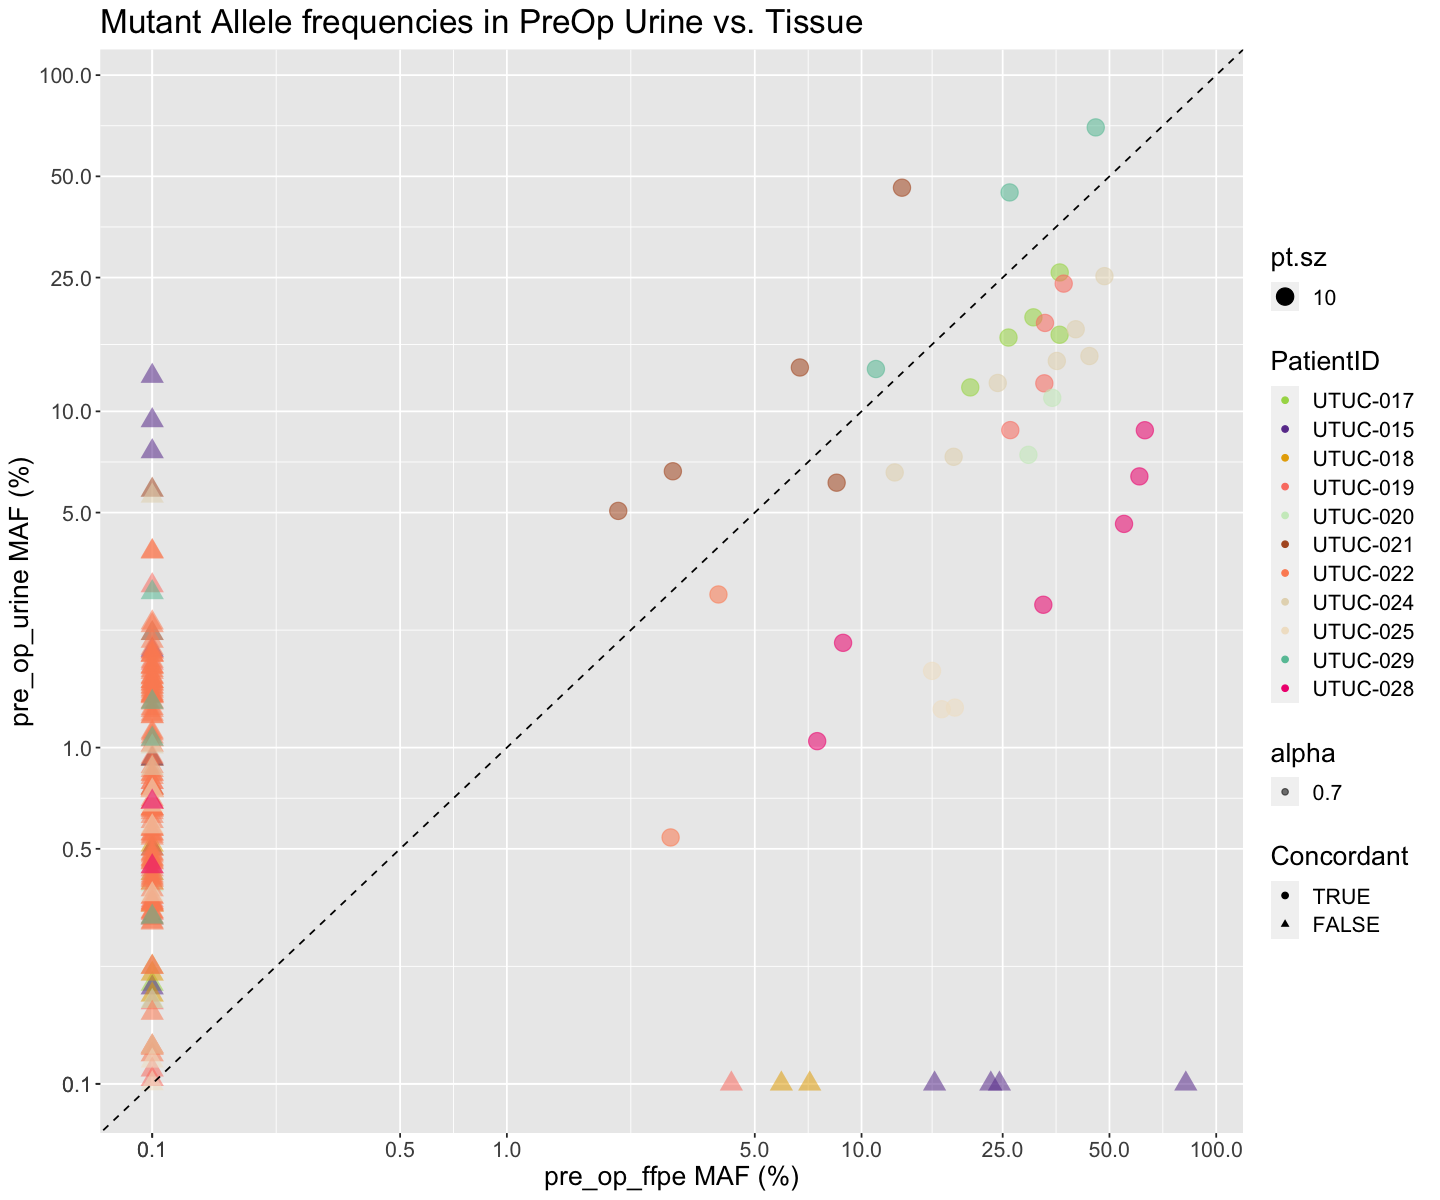

In [267]:
source("~/Desktop/puffin/R/compareMAFs.R")
source("~/Desktop/puffin/R/get_concordance_stats.R")

colors <- readRDS("colors.RDS")
out <- compareMAFs(all.snvs = all.snv_internal_no_patch,
            samples = df_ffpe_preurine_care %>% filter(PatientID %in% df_urine_preop_care$PatientID), # paired samples
            selectors = c("pre_op_ffpe","pre_op_urine"), colors=colors, text.size=16,
            plot.title = "Mutant Allele frequencies in PreOp Urine vs. Tissue", log.axes=T, fill.na=0.1) # the lod

# jpeg("./AUA_abstarct/UTUC_MAFs_urine_vs_ffpe_04182023.jpg", height=10, width=11, units="in", res=300)
# show(out$plot)
# dev.off()
jpeg("./AUA_abstarct/UTUC_Venn_urine_vs_ffpe_04242023.jpg", height=5, width=6, units="in", res=300)
concordance_venn(all.snv_internal_no_patch,
                 df_ffpe_preurine_care %>% filter(PatientID %in% df_urine_preop_care$PatientID),  # paired samples
                 selectors=c("pre_op_urine","pre_op_ffpe"),
                colors=c("pre_op_urine"="khaki","pre_op_ffpe"="cornflowerblue"), cex=2
                )
dev.off()
df = out$variants %>% filter(Concordant=="TRUE")
print(cor.test(as.numeric(df$VariantFreq.x), as.numeric(df$VariantFreq.y), method="spearman"))

Warning message in if (!(is.na(selectors))) {:
“the condition has length > 1 and only the first element will be used”


[1] "input selectors: pre_op_ffpe" "input selectors: pre_op_ucp" 


Warning message in if (is.na(colors)) {:
“the condition has length > 1 and only the first element will be used”
Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.

Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.



[1] "pre_op_ucp"
[1] 30
[1] "pre_op_ffpe"
[1] 62


pdf 
  2


	Spearman's rank correlation rho

data:  as.numeric(df$VariantFreq.x) and as.numeric(df$VariantFreq.y)
S = 956, p-value = 0.004316
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.7071429 



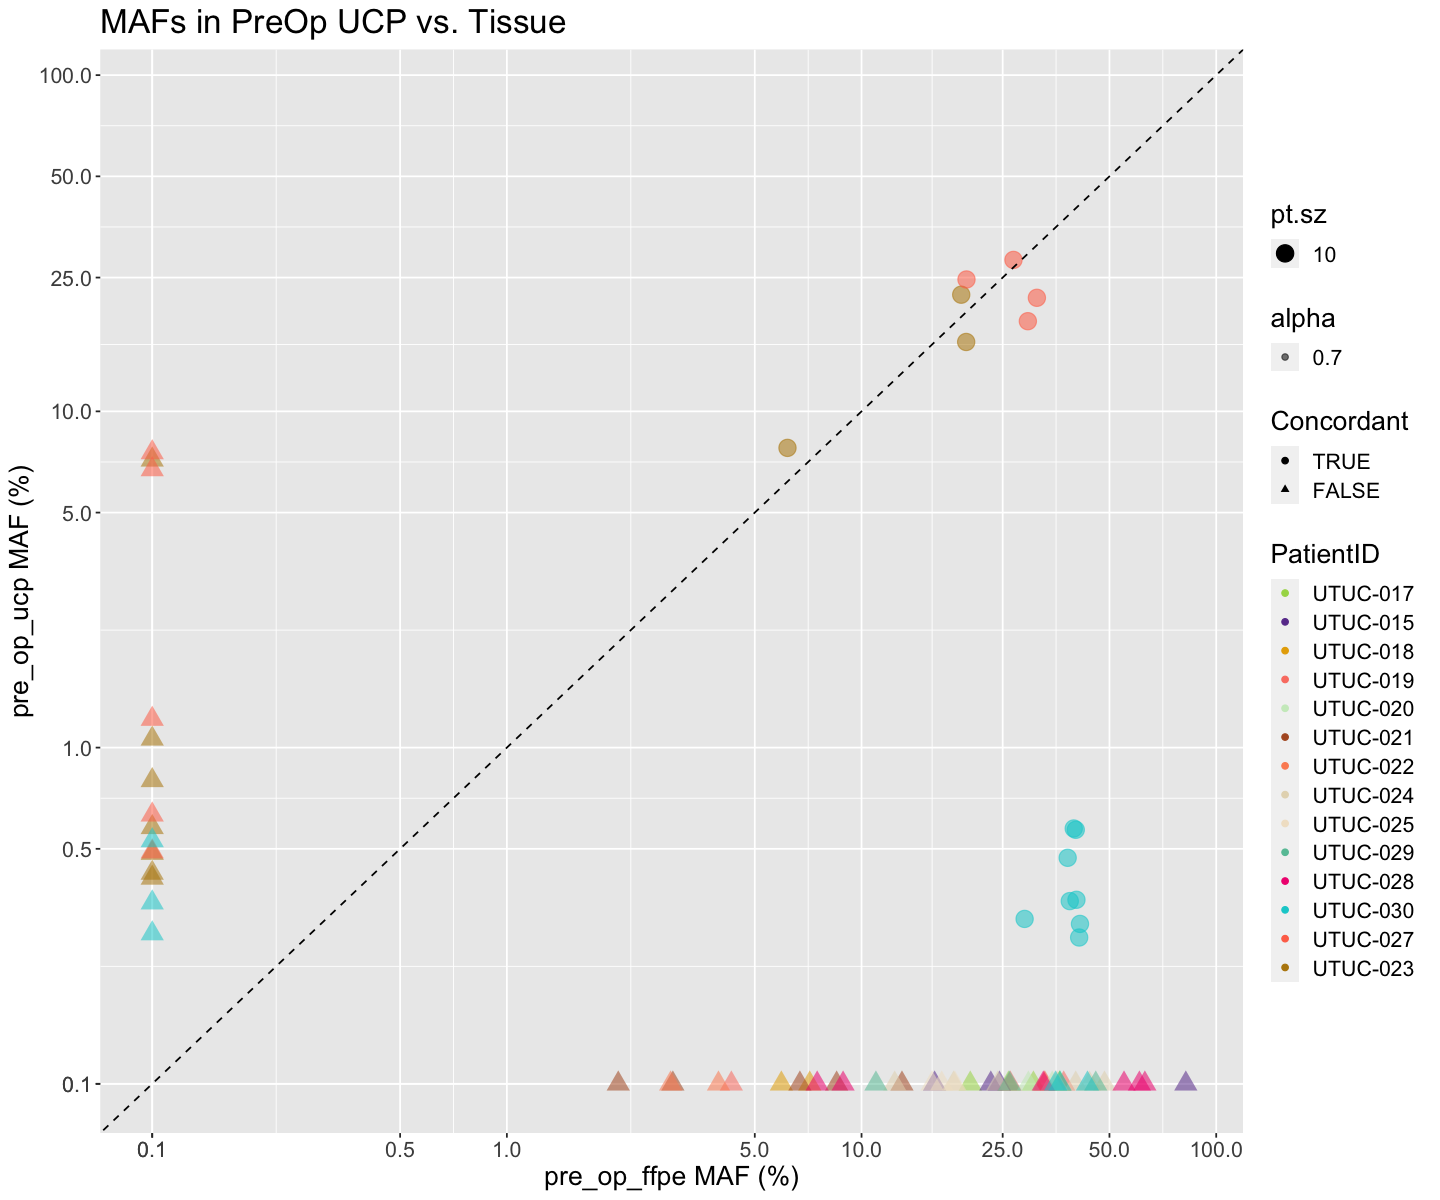

In [268]:
source("~/Desktop/puffin/R/compareMAFs.R")

colors = c(colors,c("UTUC-030"="darkturquoise","UTUC-027"="coral1","UTUC-023"="darkgoldenrod"))

out2 <- compareMAFs(all.snvs = all.snv_internal_no_patch,
            samples = df_ffpe_preucp_care %>% filter(PatientID %in% df_ucp_preop_care$PatientID), # paired samples
            selectors = c("pre_op_ffpe","pre_op_ucp"),
            plot.title = "MAFs in PreOp UCP vs. Tissue", fill.na=0.1,
            colors=colors, log.axes=T, text.size=16)

# jpeg("./AUA_abstarct/UTUC_MAFs_UCP_vs_ffpe_04182023.jpg", height=10, width=11, units="in", res=300)
# show(out2$plot)
# dev.off()

jpeg("./AUA_abstarct/UTUC_Venn_UCP_vs_ffpe_04242023.jpg", height=5, width=6, units="in", res=300)
concordance_venn(all.snv_internal_no_patch,
                 df_ffpe_preucp_care %>% filter(PatientID %in% df_ucp_preop_care$PatientID), # paired samples
                 selectors=c("pre_op_ucp","pre_op_ffpe"),
                colors=c("pre_op_ucp"="darkgoldenrod","pre_op_ffpe"="cornflowerblue"), cex=2
                )
dev.off()
df = out2$variants %>% filter(Concordant=="TRUE")
print(cor.test(as.numeric(df$VariantFreq.x), as.numeric(df$VariantFreq.y), method="spearman"))

In [313]:
## NOTE: Somatic NS snvs were only detected in 
# 3 pre-op UCP samples 023, 027, 030. We did not sequence urine for any of these patients. coincidence?
print(all.snv_internal_no_patch %>% group_by(SampleID.short, SampleType, StudyVisit, PatientID) %>%
        summarize(count=n()) %>% arrange(SampleType, StudyVisit), n=100)
unique(df_ucp_preop_care$PatientID)
unique(df_urine_preop_care$PatientID)

`summarise()` has grouped output by 'SampleID.short', 'SampleType', 'StudyVisit'. You can override using the `.groups` argument.


# A tibble: 108 × 5
# Groups:   SampleID.short, SampleType, StudyVisit [108]
    SampleID.short SampleType StudyVisit PatientID count
    <chr>          <chr>      <chr>      <chr>     <int>
  1 P213421        ffpe       pre_op     162655        7
  2 P213422        ffpe       pre_op     162759       16
  3 P213423        ffpe       pre_op     158983        2
  4 P213424        ffpe       pre_op     UTUC-001      6
  5 P213425        ffpe       pre_op     UTUC-002      2
  6 P213426        ffpe       pre_op     UTUC-003      1
  7 P213427        ffpe       pre_op     UTUC-004      9
  8 P213428        ffpe       pre_op     UTUC-005     12
  9 P213429        ffpe       pre_op     UTUC-006      3
 10 P213430        ffpe       pre_op     UTUC-007      6
 11 P213431        ffpe       pre_op     UTUC-008      2
 12 P213432        ffpe       pre_op     UTUC-009      3
 13 P213433        ffpe       pre_op     UTUC-011     14
 14 P213434        ffpe       pre_op     UTUC-012      5
 15 P213835

[1] "UTUC-015" "UTUC-017" "UTUC-018" "UTUC-019" "UTUC-020" "UTUC-021"
 [7] "UTUC-022" "UTUC-023" "UTUC-024" "UTUC-025" "UTUC-027" "UTUC-029"
[13] "UTUC-028" "UTUC-030"

[1] "UTUC-015" "UTUC-017" "UTUC-018" "UTUC-019" "UTUC-020" "UTUC-021"
 [7] "UTUC-022" "UTUC-024" "UTUC-025" "UTUC-028" "UTUC-029"

In [311]:
## 3-way overlap ## rerun with tissue informed data

source("~/Desktop/puffin/R/get_concordance_stats.R") 

# df_preop_ucp_urine_ffpe = rbind(df_ffpe_care,
#                                 df_ucp_preop_care,
#                                 df_urine_preop_care) %>%
#                          filter(PatientID %in% df_urine_preop_care$PatientID &
#                                     PatientID %in% df_ucp_preop_care$PatientID & 
#                                        PatientID %in% df_ffpe_care$PatientID) %>% 
#                                mutate("StudyVisit"=as.character(StudyVisit))
## NOTE: none of the 11 patients in this paired set have any UCP variants. Somatic NS snvs were only detected in 
# 3 pre-op UCP samples 023, 027, 030. We did not sequence failed urine for any of these patients. coincidence?
# can't run the 2-way or 3-way venn comparisons



# tissue informed ## rerun patching after v1.7.1 data available
# pdf("./completed_plus_followups/Venn_ffpe_informed_variants_UCP_Urine_09132022.pdf", width=5, height=5)

# concordance_venn(all.snv_internal_ffpe_patch,
#                  samples = df_preop_ucp_urine_ffpe, # paired samples
#                  selectors=c("pre_op_urine","pre_op_ucp","pre_op_ffpe"),
#                 colors=c("pre_op_urine"="khaki","pre_op_ucp"="darkgoldenrod","pre_op_ffpe"="cornflowerblue")
#                 )
# dev.off()

       
        pre_op
  urine    194

pre_op_urine 
         194 
WARN: missing factor levels:
[1] "pre_op_urine" "pre_op_ucp"  
         level in.test.list in.ref.list
1 pre_op_urine         TRUE        TRUE
2   pre_op_ucp         TRUE       FALSE


ERROR: Error in concordance_venn(all.snv_internal_no_patch, samples = df_preucp_preurine_care_paired %>% : concordance_venn:: WARN: No variants present for pre_op_ucp


In [287]:
unique(all.snv_internal_no_patch$StudyVisit)
unique(all.snv_internal_no_patch$SampleType)
(all.snv_internal_no_patch %>% filter(SampleType=="ucp"))

[1] "pre_op"  "postop1" "postop3" "postop2" "postop4"

[1] "ffpe"   "plasma" "urine"  "ucp"

seqnames,start,end,width,strand,ref,alt,totalDepth,refDepth,altDepth,⋯,StudyVisit,SampleType,Tumor_Seq_Allele2,Start_Position,End_Position,Reference_Allele,Mutation_Status,Variant_Type,Tumor_Sample_UUID,ID2
<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<int>,⋯,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
chr12,49434415,49434415,1,*,G,A,4491,4475,16,⋯,postop4,ucp,A,49434415,49434415,G,Somatic,SNV,P217337,P217337:chr12:49434415:G:A
chr12,49434487,49434487,1,*,G,A,4636,4609,27,⋯,postop4,ucp,A,49434487,49434487,G,Somatic,SNV,P217337,P217337:chr12:49434487:G:A
chr17,7577084,7577084,1,*,T,A,4988,4980,8,⋯,postop4,ucp,A,7577084,7577084,T,Somatic,SNV,P217337,P217337:chr17:7577084:T:A
chr5,1295228,1295228,1,*,G,A,3073,3057,16,⋯,postop4,ucp,A,1295228,1295228,G,Somatic,SNV,P217337,P217337:chr5:1295228:G:A
chrX,66863194,66863194,1,*,C,A,2534,2513,21,⋯,postop4,ucp,A,66863194,66863194,C,Somatic,SNV,P217337,P217337:chrX:66863194:C:A
chr12,1025543,1025543,1,*,G,A,3749,3734,15,⋯,postop2,ucp,A,1025543,1025543,G,Somatic,SNV,P216604,P216604:chr12:1025543:G:A
chr5,1295228,1295228,1,*,G,A,2534,2349,185,⋯,postop2,ucp,A,1295228,1295228,G,Somatic,SNV,P216604,P216604:chr5:1295228:G:A
chr7,55241726,55241726,1,*,C,T,4699,4277,422,⋯,postop2,ucp,T,55241726,55241726,C,Somatic,SNV,P216604,P216604:chr7:55241726:C:T
chr5,1295228,1295228,1,*,G,A,4332,3891,441,⋯,postop3,ucp,A,1295228,1295228,G,Somatic,SNV,P217332,P217332:chr5:1295228:G:A


## Generate oncoplots

In [ ]:
# optional filters for subset of genes

#filter1 - any gene mentioned in UTUC or Bladder lit
df_genes1 = read_excel("./UTUC Variants in Literature vs CARE (1).xlsx", sheet=2)
print(df_genes1$gene)

#filter2 - any gene mentioned in more than one lit
df_genes2 = df_genes1 %>% filter(!is.na(highlighted))
print(df_genes2$gene)

## format data for oncoprint with triangles

In [ ]:
sample_type_cols = RColorBrewer::brewer.pal(n=8, name="Set1")[c(7,6,3,1)]
names(sample_type_cols) = c("ffpe", "urine", "ucp","plasma")

sex_cols = RColorBrewer::brewer.pal(n=8, name = "Set1")[c(2,8)]
names(sex_cols) = c("Male","Female")

smoking_cols = RColorBrewer::brewer.pal(n = 8,name = "Greys")[c(2,6,8)]
names(smoking_cols) = c("Nonsmoker","Prior","Current")

path_T_cols = RColorBrewer::brewer.pal(n=8, name="Greens")[c(1,3,5:8)]
names(path_T_cols) = c("Undet.","PUNLAP/Tis/TA","T1","T2","T3","T4")

path_N_cols = RColorBrewer::brewer.pal(n=8, name="Blues")[c(1,2,4,6,8)]
names(path_N_cols) = c("Undet.","NX","N0","N1","N2")

path_grade_cols = RColorBrewer::brewer.pal(n=8, name="Oranges")[c(1,3,7)]
names(path_grade_cols) = c("Undetermined","Low Grade","High Grade")

cnb_cols = colorRamp2(c(7.5,11.5), c("white", "red4"))

stage_cols = c("grey52","black")
names(stage_cols) = c("NMI","MI/NOC")

In [ ]:
#all.cnv_external.raw = read.xlsx(all.file, sheet = "DNA_CNV")
names(all.cnv_external)
all.cnv_external_annot <- all.cnv_external %>% select(-StudyVisit) %>% 
    mutate("SampleID.short"=make_SIDshort(RequisitionID)) %>% 
    inner_join(df_ffpe_preurine_care %>% select(SampleID.short, PatientID, StudyVisit, SampleType), by="SampleID.short") %>%
    mutate("CNV_Type"=Variant_Classification) %>% unite("VariantID", c(Hugo_Symbol,Variant_Classification), remove=F)

all.snv_internal_no_patch_annot = all.snv_internal_no_patch %>% select(-PatientID) %>%
    left_join(df_ffpe_preurine_care %>% select(SampleID.short, PatientID, StudyVisit, SampleType), by="SampleID.short")

unique(df_ffpe_preurine_care$SampleType)
unique(df_ffpe_preurine_care$StudyVisit)
#unique(df_ffpe_preplasma_care$SampleID.short)

In [ ]:
source("~/Desktop/puffin/R/concordance_oncoprint.R")

var.reduc.set = list(
  c("Del", "Loss"),
  c("Amp", "Gain"),
  c("missense_variant","upstream_gene_variant", "missense_variant&splice_region_variant",
    "5_prime_UTR_variant", "stop_gained", "splice_donor_variant", "splice_acceptor_variant","SNP"),
  c("frameshift_variant","inframe_insertion",
    "stop_gained&inframe_insertion&splice_region_variant","InDel")
    )
var_color_dict2 = c(
  "SNP" = "darkgreen",
  "InDel" = "darkorange",
  "Multi_hit" = "black",
  "Gain" = "grey28",
  "Loss" = "grey65"
)

df_clinical2 = df_clinical_updated %>% select(c("PatientID","Pathologic.T.Staging","Pathologic.N.Staging","Pathologic.Grade",
                                       "Smoking.Status","Sex"))

clin_cols = list(SampleType=sample_type_cols, Sex=sex_cols, Smoking.Status=smoking_cols, 
              Pathologic.T.Staging=path_T_cols, Pathologic.N.Staging=path_N_cols, Pathologic.Grade=path_grade_cols)

out <- concordance_oncoprint(snv.data=all.snv_internal_no_patch_annot,
                             cnv.data=all.cnv_external_annot,
                             clin.data=df_clinical2,
                             df_samples=df_ffpe_preurine_care,
                             clin.data.cols=c("Pathologic.T.Staging","Pathologic.N.Staging",
                                              "Pathologic.Grade","Sex", "Smoking.Status"),
                             ref_sample_type="pre_op_ffpe",
                             mrd_sample_type="pre_op_urine",
                             show.clin.data=TRUE,
                             show.patient.id=FALSE,
                             clin.annotation.colors=clin_cols,
                             var.reduc.set=var.reduc.set,
                             var.colors=var_color_dict2,
                             make.legend=TRUE,
                             concord.barplot=TRUE,
                             #show.top.n=25,
                             genes=df_genes1$gene,
                             #alter_fun=alter_fun,
                             out.file="./AUA_abstarct/Oncoprint_preop_urine_ffpe_04192023"
                             )

In [ ]:
# get concordant counts

# ucp vs ffpe, unpatched ####
# df_concord_counts = get_max_concord_maf(all.var_internal_no_patch, "ffpe", df_samples)
# df_concord_counts = df_concord_counts %>% 
#     filter(SampleType.x %in% c("ucp"), SampleID.short %in% df_samples$SampleID.short)

# ucp vs urine, ffpe patched ####
# df_concord_counts = get_max_concord_maf(all.var_internal_ffpe_patch, "urine", df_samples)
# df_concord_counts = df_concord_counts %>% 
#     filter(SampleType.x %in% c("ucp"), SampleID.short %in% df_samples$SampleID.short)

# # urine vs ffpe unpatched ####
# df_concord_counts = get_max_concord_maf(all.var_internal_no_patch, "ffpe", df_samples)
# df_concord_counts = df_concord_counts %>% 
#     filter(SampleType.x %in% c("urine"), SampleID.short %in% df_samples$SampleID.short)


# plasma vs ffpe unpatched UTUC Subset ####
# df_concord_counts = get_max_concord_maf(all.var_internal_no_patch %>% filter(Hugo_Symbol %in% df_genes$gene), 
#                                         "ffpe", df_samples)
# df_concord_counts = df_concord_counts %>% 
#     filter(SampleType.x %in% c("plasma"), SampleID.short %in% df_samples$SampleID.short)

# plasma vs ffpe unpatched COMMON UTUC Subset
# df_concord_counts = get_max_concord_maf(all.var_internal_no_patch %>% filter(Hugo_Symbol %in% df_genes$gene[!is.na(df_genes$highlighted)]), 
#                                         "ffpe", df_samples)
# df_concord_counts = df_concord_counts %>% 
#     filter(SampleType.x %in% c("plasma"), SampleID.short %in% df_samples$SampleID.short)

# plasma vs ffpe unpatched ####
df_concord_counts = get_max_concord_maf(all.var_internal_no_patch, "ffpe", df_samples)
df_concord_counts = df_concord_counts %>% 
    filter(SampleType.x %in% c("plasma"), SampleID.short %in% df_samples$SampleID.short)

# format
stopifnot(length(df_concord_counts$PatientID.x) == length(unique(df_concord_counts$PatientID.x))) #check dupes
df_concord_counts = df_concord_counts %>%
    mutate(n_concord_vars = as.numeric(n_concord_vars), n_sample_vars = as.numeric(n_sample_vars)) %>%
    mutate(diff= n_sample_vars - n_concord_vars) 
head(df_concord_counts)

In [ ]:
# summarize variant data for each sample type ##RERUN
df_concord_counts$pct_concord = 1 - (df_concord_counts$diff/df_concord_counts$n_sample_vars)

print(sprintf("boxplot pct concord: %s (%s - %s)", mean(df_concord_counts$pct_concord, na.rm=T),
                                             min(df_concord_counts$pct_concord, na.rm=T),
                                            max(df_concord_counts$pct_concord, na.rm=T)))

summarize_vars <- function(df, sample_type_){
  print(sample_type_)
  s= df %>% filter(sample_type==sample_type_)%>% right_join(df_samples %>% filter(SampleType==sample_type_) %>%
                                                                           select(Tumor_Sample_Barcode, Stage), by="Tumor_Sample_Barcode") %>% # add back samples w zero variants
    group_by(Tumor_Sample_Barcode) %>%
    summarize(n_cnv=sum(Variant_Classification %in% c("Amp","Del")),
              n_snp=sum(Variant_Classification %in% c('Missense_Mutation','Nonsense_Mutation',
                                                            '5pFlank','5pUTR','Splice_Site')),
              n_indel=sum(Variant_Classification %in% c('Frame_Shift_Del','Frame_Shift_Ins',
                                                        'In_Frame_Ins','In_Frame_Del')))
  print(s)
  print(s %>% select(-c("Tumor_Sample_Barcode")) %>% pivot_longer(everything()) %>% group_by(name) %>%
              summarise_at(vars(value), list(Min = min, Mean = mean, Max = max, Median = median, Total=sum)))
    }


###
summarize_vars(df_data, "ffpe")

summarize_vars(df_data, "urine")

summarize_vars(df_data, "ucp")

summarize_vars(df_data, "plasma")



#head(df_concord_counts)

## Calculate urine stats

In [ ]:
# LPWGS data stored here: 
# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/

# CNB PBMC background vs. FFPE: 
# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/ffpe/wgsSummary_pbmcBaseline/

df_ffpe_vs_pbmc = read.csv("./completed_plus_followups/lpwgs/ffpe/FFPE_vs_pbmc/PRDC-MOFFITT-UTUCBC_ffpe_lpwgsQC_vs_PBMC_bkgd.csv",
                              as.is=T) %>% 
                    mutate("SampleID.short"=make_SIDshort(SampleID)) %>%
                    select(SampleID.short, cnbScore)

## replace with TMB and ATLAS updated stats ## TODO
df_urine_preop_lpwgs = df_urine %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk")) 

df_plasma_preop_lpwgs = df_plasma %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))

names(df_urine_preop_lpwgs)

In [ ]:
# Urine variant count and TF data

counts_urine_var = extract_counts(all.var_internal_no_patch, df_urine_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_var"=n_variants)
counts_urine_snv = extract_counts(all.snv_internal_no_patch, df_urine_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv"=n_variants)
counts_urine_snv_path = extract_counts(all.snv_nopatch_path, df_urine_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv_path"=n_variants)
counts_urine_cnv = extract_counts(all.cnv_external, df_urine_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_cnv"=n_variants)

df_model_data_urine = df_urine_preop_care %>% select(SampleID.short, PatientID, SampleType, StudyVisit) %>%
                                         left_join(counts_urine_var, by=c("PatientID","SampleID.short")) %>% 
                                         left_join(counts_urine_snv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_urine_snv_path, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_urine_cnv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(df_urine_preop_lpwgs %>%
                                                   select(SampleID.short, cnbScore, tumorFraction.updated, 
                                                          pTMB.norm.weighted.updated, tumorFraction, pTMB_norm.weighted),
                                                           by=c("SampleID.short")) %>%
                                         left_join(df_clinical_updated, by="PatientID") %>%
                                         select(SampleID.short, PatientID, 
                                                cnbScore, tumorFraction, pTMB_norm.weighted,
                                                tumorFraction.updated, pTMB.norm.weighted.updated,
                                                n_var, n_snv, n_snv_path, n_cnv,
                                                Age.at.Surgery, Preop.Hemoglobin, Sex, Smoking.Status, Personal.History.of.Bladder.cancer, 
                                                Clinical.T.Staging.byT2, Tumor.architecture, 
                                                Laterality, Stage)

# fill.na
df_model_data_urine$tumorFraction[df_model_data_urine$n_snv==0] <- 0.0
df_model_data_urine$tumorFraction.updated[df_model_data_urine$n_snv==0] <- 0.0
df_model_data_urine$pTMB_norm.weighted[df_model_data_urine$n_snv==0] <- 0.0
df_model_data_urine$pTMB.norm.weighted.updated[df_model_data_urine$n_snv==0] <- 0.0


names(df_model_data_urine)
df_model_data_urine[3:13] <- apply(df_model_data_urine[3:13], 2, as.numeric)
head(df_model_data_urine)
warn_na(df_model_data_urine)

In [314]:
## pre vs post urine CNB

pre_post_plot <- function(df, stat){
 print(stat)
 formula = as.formula(paste0(stat,"~ StudyVisit"))
 res <- wilcox.test(formula, data = df, exact = FALSE, paired=FALSE)
 print(res)
    
 df_plot = df[,c("StudyVisit","PatientID",stat)]
 df_dir = df_plot %>% group_by(PatientID) %>% rename("stat"={{stat}}) %>%
        summarize(direction=ifelse(n()<1, NA, 
                                   ifelse((stat[StudyVisit=="pre_op"]-stat[StudyVisit=="postop1"])>0,"decrease",
                                                        ifelse((stat[StudyVisit=="pre_op"]-stat[StudyVisit=="postop1"])==0,"neutral","increase")))) 
 df_plot = df_plot %>% left_join(df_dir, by="PatientID")
 #print(df_plot)
 box_cols = RColorBrewer::brewer.pal(n=8,"Paired")[c(1,5)]
 names(box_cols) = c("postop1","pre_op")
    
 gg <- ggplot(df_plot, aes_string(x="StudyVisit", y=stat, fill="StudyVisit")) + 
  geom_boxplot(outlier.shape=NA) +
  scale_fill_manual(name="StudyVisit", values=box_cols, labels=c("Post-Op","Pre-Op")) + 
  geom_point(size=4, pch=1) +
  geom_line(aes(group = PatientID, colour = direction), linetype = "dashed") +
  scale_color_manual(values=c("decrease"="blue","increase"="red","neutral"="grey")) +
  #facet_grid(. ~ factor(SampleType, levels=c("plasma","urine"))) +
  labs(y=stat, title=stat, x="") + 
  theme(text = element_text(size = 14),
        #strip.text = element_text(size=20),
        axis.ticks = element_blank(), 
        axis.text.x = element_blank(),
        legend.position="right")
 show(gg)
}

df_plot = df_urine %>% filter(qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"),
                             StudyVisit %in% c("pre_op","postop1"))
nrow(df_plot)
names(df_plot)

jpeg("./AUA_abstarct/pre_post_urine_CNB_boxplot_04182023.jpg", units="in", width=5, height=5, res=300)
pre_post_plot(df_plot %>% rename("Urine.CNB.Score"="cnbScore"), "Urine.CNB.Score")
dev.off()

#pre_post_plot(df_plot, "tumorFraction") # only one postop value
#pre_post_plot(df_plot, "tumorFraction.updated") # only one postop value


[1] 18

[1] "SampleID.x"                   "SampleID.lpwgs"              
 [3] "finalKeep"                    "PatientID"                   
 [5] "qcLabel.lpwgs.mapping."       "StudyVisit"                  
 [7] "SampleType"                   "DNAYield"                    
 [9] "LibraryYield"                 "Proceed.LPWGS"               
[11] "ProjectDir.lpwgs"             "PatientID.lpwgs"             
[13] "coverage"                     "Mapping.rate...."            
[15] "cnbScore"                     "wgsTumorfrac_EM"             
[17] "externalSampleID.lpwgs"       "Batch"                       
[19] "Proceed.CARE.panel.NGS"       "LibraryQC.input.panel"       
[21] "QC_Status.panel"              "total_dna_input"             
[23] "total_cfdna_input"            "library_dna_input_ug"        
[25] "enriched_library_fa_or_ba_nm" "maxAF_TMB"                   
[27] "Specimen_type"                "ProjectDir.panel"            
[29] "work_order"                   "sampleFolder"                
[31] "pTMB.weighted"                "pTMB_norm.weighted"          
[33] "tumorFraction"                "PatientID.panel"             
[35] "externalSampleID.panel"       "trialVisitNum"               
[37] "Notes"                        "X38"                         
[39] "SampleID.short"               "Stage"                       
[41] "SampleID.y"                   "pTMB.norm.weighted.updated"  
[43] "tumorFraction.updated"        "maxAF_TMB.updated"

[1] "Urine.CNB.Score"

	Wilcoxon rank sum test with continuity correction

data:  Urine.CNB.Score by StudyVisit
W = 61, p-value = 0.005779
alternative hypothesis: true location shift is not equal to 0



pdf 
  2

## signif by gene for bladder recurrence and stage

In [ ]:
df_clinical_updated$Stage.bool = ifelse(is.na(df_clinical_updated$Muscle.invasive.or.Non.organ.confined),FALSE, TRUE)
print(df_clinical_updated$Stage.bool)

df_clinical_updated$uro.recurence.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Urothelial"),TRUE,FALSE)
print(df_clinical_updated$uro.recurence.bool)

df_clinical_updated$metastisis.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Metastasis"),TRUE,FALSE)
print(df_clinical_updated$metastisis.bool)

df_clinical_updated$recur.or.metastisis.bool = (df_clinical_updated$uro.recurence.bool | df_clinical_updated$metastisis.bool)
print(df_clinical_updated$recur.or.metastisis.bool)

In [ ]:
get_fisher_data <- function (df_all_variants, df_samples){
    print(nrow(df_samples))
    df_variants_sel = df_all_variants %>% inner_join(df_samples %>% select(SampleID.short, SampleType), by="SampleID.short")
    genes = unique(df_variants_sel$Hugo_Symbol)
    #print(genes)
    patients = unique(as.character(df_samples$PatientID))
    fisher_data = list()
    for (patient in patients){
        print(patient)
        df_patient = df_variants_sel %>% filter(PatientID==patient)
        #print(nrow(df_patient))
        if (nrow(df_patient) == 0){
            patient_data_by_gene_bool = rep(FALSE,length(genes))
        }else{
            patient_data_by_gene_bool = vector()
            for (gene in genes){
                #print(gene)
                df_gene = df_patient %>% filter(Hugo_Symbol==gene)
                #print(nrow(df_gene))
                if (nrow(df_gene) > 0){
                    mutated = TRUE
                }else{
                    mutated = FALSE
                }
                patient_data_by_gene_bool = c(patient_data_by_gene_bool, mutated)
        }}
        stopifnot(length(patient_data_by_gene_bool)==length(genes))
        fisher_data[[patient]] <- patient_data_by_gene_bool
        }
    
    df_fisher_data = do.call(cbind, fisher_data)
    rownames(df_fisher_data) = genes
    return(df_fisher_data)
    }

In [ ]:
library(stats)

assoc_test <- function(df_fisher_data, df_clinical_updated){
    # order stage labels by column pids
    stage_filter = df_clinical_updated$Stage.bool[match(colnames(df_fisher_data), df_clinical_updated$PatientID)]
    brecur_filter = df_clinical_updated$uro.recurence.bool[match(colnames(df_fisher_data), df_clinical_updated$PatientID)]
    met_filter = df_clinical_updated$metastisis.bool[match(colnames(df_fisher_data), df_clinical_updated$PatientID)]
    both_filter = df_clinical_updated$recur.or.metastisis.bool[match(colnames(df_fisher_data), df_clinical_updated$PatientID)]
    #print(brecur_filter)
                           
    ft <- function(row){
      mat = matrix(row, nrow=2, byrow=TRUE)
      #print(mat)
      return(fisher.test(mat)$p.value)}
    
    # STAGE
    df_fisher_test_stage = NULL
    print(stage_filter)
    if (sum(stage_filter) >= 2){
        late_mutated = rowSums(df_fisher_data[,stage_filter])
        #print(late_mutated)
        late_nonmutated = rowSums(!(df_fisher_data[,stage_filter]))
        #print(late_nonmutated)
        early_mutated = rowSums(df_fisher_data[,!(stage_filter)])
        #print(early_mutated)
        early_nonmutated = rowSums(!(df_fisher_data[,!(stage_filter)]))
        #print(early_nonmutated)
        df_fisher_test_stage = data.frame("early_nonmutated"=early_nonmutated, "late_nonmutated"=late_nonmutated,
                                    "early_mutated"=early_mutated, "late_mutated"=late_mutated)
        #print(head(df_fisher_test_stage))
        df_fisher_test_stage$p_value = apply(df_fisher_test_stage, 1, ft)
        df_fisher_test_stage$signif = ifelse(df_fisher_test_stage$p_value <0.05, "*", "")
        print("STAGE")
        print(df_fisher_test_stage)
        
        }
    
    # BLADDER RECUR 
    df_fisher_test_recur = NULL
    print(brecur_filter)
    if (sum(brecur_filter) >= 2){
        recur_mutated = rowSums(df_fisher_data[,brecur_filter])
        recur_nonmutated = rowSums(!(df_fisher_data[,brecur_filter]))
        nonrecur_mutated = rowSums(df_fisher_data[,!(brecur_filter)])
        nonrecur_nonmutated = rowSums(!(df_fisher_data[,!(brecur_filter)]))
        df_fisher_test_recur = data.frame("nonrecur_nonmutated"=nonrecur_nonmutated, "recur_nonmutated"=recur_nonmutated,
                                    "nonrecur_mutated"=nonrecur_mutated, "recur_mutated"=recur_mutated)
        df_fisher_test_recur$p_value = apply(df_fisher_test_recur, 1, ft)
        df_fisher_test_recur$signif = ifelse(df_fisher_test_recur$p_value <0.05, "*", "")
        print("BLADDER RECUR")
        print(df_fisher_test_recur)
        }
    
    # Met RECUR
    df_fisher_test_met = NULL
    print(met_filter)
    if (sum(met_filter) >= 2){
        met_mutated = rowSums(df_fisher_data[,met_filter])
        met_nonmutated = rowSums(!(df_fisher_data[,met_filter]))
        nonmet_mutated = rowSums(df_fisher_data[,!(met_filter)])
        nonmet_nonmutated = rowSums(!(df_fisher_data[,!(met_filter)]))
        df_fisher_test_met = data.frame("nonmet_nonmutated"=nonmet_nonmutated, "met_nonmutated"=met_nonmutated,
                                    "nonmet_mutated"=nonmet_mutated, "met_mutated"=met_mutated)
        df_fisher_test_met$p_value = apply(df_fisher_test_met, 1, ft)
        df_fisher_test_met$signif = ifelse(df_fisher_test_met$p_value <0.05, "*", "")
        print("MET RECUR")
        print(df_fisher_test_met)
        }
    
    # Met+Uro RECUR (either uro or met recurr patients)
    df_fisher_test_both = NULL
    print(both_filter)
    if (sum(both_filter) >= 2){
        both_mutated = rowSums(df_fisher_data[,both_filter])
        both_nonmutated = rowSums(!(df_fisher_data[,both_filter]))
        nonboth_mutated = rowSums(df_fisher_data[,!(both_filter)])
        nonboth_nonmutated = rowSums(!(df_fisher_data[,!(both_filter)]))
        df_fisher_test_both = data.frame("nonboth_nonmutated"=nonboth_nonmutated, "both_nonmutated"=both_nonmutated,
                                    "nonboth_mutated"=nonboth_mutated, "both_mutated"=both_mutated)
        df_fisher_test_both$p_value = apply(df_fisher_test_both, 1, ft)
        df_fisher_test_both$signif = ifelse(df_fisher_test_both$p_value <0.05, "*", "")
        print("MET or URO RECUR")
        print(df_fisher_test_both)
        }
    # # add log odds ratios
# df_urine_stage$OR = log(df_urine_stage$late_freq / df_urine_stage$early_freq)
# # reorder the columns
# df_urine_stage2 = df_urine_stage %>% 
#     filter(pct_mutated>(2/11)) %>% 
#     arrange(OR)                     
    return(list("stage"=df_fisher_test_stage, "uro_recur"=df_fisher_test_recur,
               "met_recur"=df_fisher_test_met, "both_recur"=df_fisher_test_both))
}

In [ ]:
library(pROC)
library(caret)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA, save.as=NA){
     #print(df[,label_col])
#     print(score_col)
    options(repr.plot.width=5, repr.plot.height=5)
    
    print(sum(!is.na(df[1:nrow(df),score_col])))
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) >= thresh))
      FN = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) < thresh))
      TN = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) < thresh))
      FP = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) >= thresh))
      print(label_col %in% names(df))
      print(score_col %in% names(df))
      print(paste0("TP: ",TP))
      print(paste0("FP: ",FP))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }

    pROC_obj <- roc_(data=df, response=label_col, 
                predictor=score_col, smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    
    if (!is.na(title)){
       if (!is.na(save.as)){
          pdf(save.as, width=8, height=8)}
        
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE,  
                print.thres=thresh,
                print.thres.cex=1.5,
                print.auc.cex=1.5,
                cex.axis=1.5,
                main=title)
        #text(0.4, 0.4, paste("AUC:", round(pROC_obj$auc, 3)))
       
       dev.off()
    }
    
    print(coords(pROC_obj, x="best"))
    ss_ci = ci(pROC_obj, of = "coords", "best", best.policy="random") # what to do when bootstrap replicates produce more than one "best" point
    print(ss_ci)
    
    print(paste0("AUC: ", auc(pROC_obj)))
    auc_ci <- ci(pROC_obj, of = "auc")
    print(auc_ci)
}

# count variants

extract_counts <- function(df_variants, df_samples_){
    df_var_selected = df_variants %>% filter(SampleID.short %in% df_samples_$SampleID.short)
    df_counts = df_var_selected %>% group_by(SampleID.short) %>% 
        # summarize(n_variants=n(), max_MAF=max(VariantFreq)) %>%
        summarize(n_variants=n()) %>%
        right_join(df_samples_ %>% select(SampleID.short, PatientID, SampleType, StudyVisit, Stage), by="SampleID.short")
    df_counts$n_variants[is.na(df_counts$n_variants)] <- 0 #one count per reqid
    df_counts$Stage = as.factor(df_counts$Stage)
    df_counts = df_counts %>% filter(PatientID!="UTUC-026")
    return(df_counts)}

In [ ]:
# urine staging sensitivity

# unpatched
counts = extract_counts(all.var_internal_no_patch, df_urine_preop_care) 
print("Pre_urine Unpatched")
get_sens_spec(counts, "Stage", "n_variants")

counts = extract_counts(all.var_internal_ffpe_patch, df_ffpe_preurine_care %>% filter(SampleType=="urine")) 
print("Pre_urine FFPE patched")
get_sens_spec(counts, "Stage", "n_variants")

# counts = extract_counts(all.var_internal_urine_patch, df_preplasma_preurine_care %>% filter(SampleType=="plasma")) 
# print("Pre_plasma Urine patched")
# get_sens_spec(counts, "Stage", "n_variants")

# counts = extract_counts(all.var_patched_ffpe_urine_internal, df_preplasma_preurine_care %>% 
#                                                                 filter(PatientID %in% df_ffpe_care$PatientID)) 
# print("Pre_plasma Urine and FFPE patched")
# get_sens_spec(counts, "Stage", "n_variants",
#              title=">=T2 Detection, Pre_plasma Urine and FFPE patched")

In [ ]:
## LOOCV for plasma n_var counts - for CV AUC see bootstrap CI inteval for AUC above
nrow(df_counts)
df_counts$Stage.bin = factor(df_counts$Stage, levels=c("early","late"))
df_counts$n_variants = as.numeric(df_counts$n_variants)
#specify the cross-validation method
ctrl <- trainControl(method = "LOOCV", summaryFunction = twoClassSummary, savePredictions = TRUE, classProbs=TRUE)

#fit a regression model and use LOOCV to evaluate performance
model <- train(Stage.bin ~ n_variants, data = df_counts, method = "glm", family="binomial", trControl = ctrl, metric="Sens")

#view summary of LOOCV      ## some probs = 0 because there are no plasma variants         
model$pred

get_sens_spec(model$pred, label_col="obs", score_col="late")

In [ ]:
# UCP staging sensitivity

# unpatched
counts = extract_counts(all.var_internal_no_patch, df_ucp_preop_care) 
print("Pre_ucp Unpatched")
get_sens_spec(counts, "Stage", "n_variants")

counts = extract_counts(all.var_internal_ffpe_patch, df_ffpe_preucp_care %>% filter(SampleType=="ucp")) 
print("Pre_ucp FFPE patched")
get_sens_spec(counts, "Stage", "n_variants")

counts = extract_counts(all.var_internal_urine_patch, df_ucp_preop_care %>% filter(PatientID %in% df_urine_preop_care$PatientID))
                                                                               
print("Pre_ucp Urine patched")
get_sens_spec(counts, "Stage", "n_variants")

counts = extract_counts(all.var_patched_ffpe_urine_internal, df_ucp_preop_care %>% 
                                                                filter(PatientID %in% df_ffpe_preurine_care$PatientID)) 
print("Pre_ucp Urine and FFPE patched")
get_sens_spec(counts, "Stage", "n_variants")


In [ ]:
# concordant variants ffpe vs. urine

#unpatched
counts = count_concordant(all.var_internal_no_patch, df_ffpe_preurine_care)
print("Pre urine and FFPE Concordant Unpatched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var")

# ffpe patch
counts = count_concordant(all.var_internal_ffpe_patch, df_ffpe_preurine_care)
print("Pre_urine and FFPE Concordant ffpe patched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var")


In [ ]:
# concordant variants ffpe vs. ucp

#unpatched
counts = count_concordant(all.var_internal_no_patch, df_ffpe_preucp_care)
print("Pre ucp and FFPE Concordant Unpatched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var")

# ffpe patch
counts = count_concordant(all.var_internal_ffpe_patch, df_ffpe_preucp_care)
print("Pre_ucp and FFPE Concordant ffpe patched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var")

# concordant urine/ucp
# no patch
counts = count_concordant(all.var_internal_no_patch, df_preucp_preurine_care)
print("Pre_ucp and Urine Concordant urine patched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var")

# urine patch
counts = count_concordant(all.var_internal_urine_patch, df_preucp_preurine_care)
print("Pre_ucp and Urine Concordant urine patched")
get_sens_spec(counts %>% distinct(PatientID, .keep_all=TRUE), "Stage", "n_concord_var", title="urine/ucp concord")


## boxplots of variant counts

In [226]:
# boxplot preop urine vs ucp, unpatched vs patched w ffpe

df_preop_counts_unpatch = extract_counts(all.var_internal_no_patch, df_preucp_preurine_care) # all have ffpe
#head(df_preop_counts_unpatch) #n=11 patients

df_preop_counts_patch = extract_counts(all.var_internal_ffpe_patch, df_preucp_preurine_care) # all have ffpe

print(df_preop_counts_unpatch %>% left_join(df_preop_counts_patch, by="SampleID.short") %>% 
              arrange(SampleType.x,PatientID.x) %>% select(PatientID.x, SampleType.x, n_variants.x, n_variants.y),
     n=50)
stop()
df_plot = rbind(df_preop_counts_unpatch %>% mutate(method="un-informed"),
                df_preop_counts_patch %>% mutate(method="tissue-informed"))
df_plot$method = factor(df_plot$method, levels=c("un-informed","tissue-informed"))

options(repr.plot.width=12, repr.plot.height=10)
#pdf("./manuscript/Fig_n_variants_boxplot.pdf", width=10, height=10)

g <- ggplot(df_plot, 
            aes(x=SampleType, y=n_variants, fill=SampleType)) + 
  geom_boxplot(outlier.shape = NA) +  
  geom_point(position=position_jitterdodge(), size=4, pch=1) + 
  facet_grid(. ~ method) +
  labs(y="No.variants", title="") + 
  scale_fill_manual(name = "sample type", labels=c("UCP","Urine Supe."), values=c("goldenrod4","goldenrod2")) +
  #ylim(0,30) +
  theme(text = element_text(size = 20),
        strip.text = element_text(size=20),
        axis.ticks = element_blank(), 
        axis.text.x = element_blank())

#print(g)
#dev.off()

print(g)
# caption: one outlier not shown with >30 variants in urine

# A tibble: 22 × 4
   PatientID.x SampleType.x n_variants.x n_variants.y
   <chr>       <chr>               <dbl>        <dbl>
 1 UTUC-015    ucp                     1            5
 2 UTUC-017    ucp                    10           15
 3 UTUC-018    ucp                     0            2
 4 UTUC-019    ucp                     0            5
 5 UTUC-020    ucp                     2            4
 6 UTUC-021    ucp                     4            9
 7 UTUC-022    ucp                     1            3
 8 UTUC-024    ucp                     0            7
 9 UTUC-025    ucp                     0            3
10 UTUC-028    ucp                     0            6
11 UTUC-029    ucp                     8           11
12 UTUC-015    urine                   6            6
13 UTUC-017    urine                  22           21
14 UTUC-018    urine                   6            6
15 UTUC-019    urine                  18           20
16 UTUC-020    urine                   6            6
17 UTUC-0

ERROR: Error in eval(expr, envir, enclos): 


[1] "UTUC-008" "UTUC-017" "UTUC-018" "UTUC-022" "UTUC-022" "UTUC-029" "UTUC-028"

[1] "urine"  "plasma" "urine"  "plasma" "urine"  "urine"  "urine"

[1] "chr12:49444975:A:G"  "chr5:1295243:G:A"    "chr4:153244155:TC:T"
[4] "chr11:125513690:C:T" "chr11:125513690:C:T" "chr22:29090089:C:A" 
[7] "chr4:55598125:C:A"

[1] "merge_info::"


warn_na: WARN: NA or missing values in finalKeep: 3



[1] "merge_info::"


warn_na: WARN: NA or missing values in sampleFolder: 130



[1] "merge_info::"


warn_na: WARN: NA or missing values in SampleType: 5



[1] 9

In [ ]:
# check unpatched >= patched
df = full_join(df_preop_counts_unpatch, df_preop_counts_patch, by=c("PatientID","SampleType"))
# see missing_variats_10192022.csv
df$diff = df$n_variants.y - df$n_variants.x

df_urine = df %>% filter(SampleType=="urine")
print(max(df_urine$diff))
mean(df_urine$diff)

df_ucp = df %>% filter(SampleType=="ucp")
print(max(df_ucp$diff))
mean(df_ucp$diff)

In [ ]:
# get signifs
print("urine vs ucp, uninformed (w/outlier)")
df = df_plot %>% filter(method=="un-informed")
nrow(df)
print(mean(df$n_variants[df$SampleType=="urine"], na.rm=T))
print(mean(df$n_variants[df$SampleType=="ucp"], na.rm=T))
res <- wilcox.test(n_variants ~ SampleType,
                   data = df,
                   paired = TRUE,
                   exact = FALSE)
res

print("urine vs ucp, uninformed (w/o outlier)")
df = df_plot %>% filter(method=="un-informed", PatientID!="UTUC-022")
nrow(df)
print(mean(df$n_variants[df$SampleType=="urine"], na.rm=T))
print(mean(df$n_variants[df$SampleType=="ucp"], na.rm=T))
res <- wilcox.test(n_variants ~ SampleType,
                   data = df,
                   paired = TRUE,
                   exact = FALSE)
res



print("urine vs ucp, tissue-informed (w/outlier)")
df = df_plot %>% filter(method=="tissue-informed")
nrow(df)
print(mean(df$n_variants[df$SampleType=="urine"], na.rm=T))
print(mean(df$n_variants[df$SampleType=="ucp"], na.rm=T))
res <- wilcox.test(n_variants ~ SampleType,
                   data = df,
                   paired = TRUE,
                   exact = FALSE)
res

print("urine vs ucp, tissue-informed (w/o outlier)")
df = df_plot %>% filter(method=="tissue-informed", PatientID!="UTUC-022")
nrow(df)
print(mean(df$n_variants[df$SampleType=="urine"], na.rm=T))
print(mean(df$n_variants[df$SampleType=="ucp"], na.rm=T))
res <- wilcox.test(n_variants ~ SampleType,
                   data = df,
                   paired = TRUE,
                   exact = FALSE)
res



## analysis of tumor fraction, TMB, and CNB

In [ ]:
# use data input code above

# LPWGS data stored here: 
# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/

# CNB PBMC background vs. FFPE: 
# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/ffpe/wgsSummary_pbmcBaseline/

df_ffpe_vs_pbmc = read.csv("./completed_plus_followups/lpwgs/ffpe/FFPE_vs_pbmc/PRDC-MOFFITT-UTUCBC_ffpe_lpwgsQC_vs_PBMC_bkgd.csv",
                              as.is=T) %>% 
                    mutate("SampleID.short"=make_SIDshort(SampleID)) %>%
                    select(SampleID.short, cnbScore)

## replace with TMB and ATLAS updated stats ## TODO
df_urine_preop_lpwgs = df_urine %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk")) 

df_plasma_preop_lpwgs = df_plasma %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))

names(df_urine_preop_lpwgs)

In [ ]:
 # box plots urine CNB   
options(repr.plot.width=10, repr.plot.height=10)

df_plot_data = df_model_data_urine %>%
                filter(#tumorFraction >= 0.01, # cnb not always reliable below this lod
                       !is.na(cnbScore)) %>%
                mutate("Stage"=factor(Stage, levels=c("NMI","MI/NOC")))

# get signif
print("Urine")
df = df_plot_data #%>% filter(SampleType=="plasma")
print(mean(df$cnbScore[df$Stage=="NMI"], na.rm=T))
print(mean(df$cnbScore[df$Stage=="MI/NOC"], na.rm=T))
res <- wilcox.test(cnbScore ~ Stage,
                   data = df,
                   exact = FALSE)
res
urine_p=as.character(round(res$p.value, 3))

# print("FFPE")
# df = df_plot_data %>% filter(SampleType=="ffpe")
# print(mean(df$cnbScore[df$Stage=="NMI"], na.rm=T))
# print(mean(df$cnbScore[df$Stage=="MI/NOC"], na.rm=T))
# res <- wilcox.test(cnbScore ~ Stage,
#                    data = df,
#                    exact = FALSE)
# res
# tissue_p=as.character(round(res$p.value, 3))

# ann_text <- data.frame(Stage = 0.5, #x coord
#                        cnbScore = max . .. , # y coord
#                        lab = c(tissue_p,plas_p),
#                        SampleType = c("ffpe","plasma"))
# plot by stage
pdf("./manuscript/CNB_boxplots_03072023.pdf", height=5, width=7)
#pdf("./manuscript/CNB_and_Nvar_boxplots_12192022.pdf", height=8, width=8)
#pdf("./manuscript/CNB_boxplots_02012023.pdf", height=8, width=8)

pp <- ggplot(df_plot_data, aes(x=Stage, y=cnbScore, fill=Stage)) + 
  geom_boxplot(outlier.shape = NA) +  
  geom_point(position=position_jitterdodge(), size=4, pch=1) +
  #geom_text(data = ann_text, label="Text", size=22) + 
  facet_grid(. ~ SampleType) +
  labs(y="CNB Score", c="") +
  scale_fill_manual(name="Pathologic.Stage",values=c("darkturquoise","coral1")) +
  theme(text = element_text(size = 16),
        strip.text = element_text(size=20),
        axis.ticks = element_blank(), 
        axis.text.x = element_blank(),
       axis.text.y = element_text(size=16))
print(pp)
dev.off()

print(pp)


In [ ]:
# ROC curves for CNB
get_sens_spec(df_plot_data %>% filter(SampleType=="ffpe"), "Stage", "cnbScore",
              #thresh=7.768,
              title="Predict MI/NOC by FFPE Copy Number Burden",
              #save.as="./manuscript/supp_fig7b_CNB_ROC_urine.pdf"
             )
get_sens_spec(df_plot_data %>% filter(SampleType=="plasma"), "Stage", "cnbScore",
              #thresh=7.768,
              title="Predict MI/NOC by Plasma Copy Number Burden",
              #save.as="./manuscript/supp_fig7b_CNB_ROC_urine.pdf"
             )


In [ ]:
library(pROC)
options(repr.plot.width=5, repr.plot.height=5)

get_sens_spec <- function(df, label_col, score_col, title=NA, thresh=NA){
#     print(label_col)
#     print(score_col)
    print(sum(!is.na(df[1:nrow(df),score_col])))
    print(sprintf("case/control: %s / %s", sum(df[1:nrow(df),label_col]==1), sum(df[1:nrow(df),label_col]==0)))
    if (!is.na(thresh)){
      TP = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) >= thresh))
      FN = nrow(df %>% filter(!!rlang::sym(label_col)=="late", !!rlang::sym(score_col) < thresh))
      TN = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) < thresh))
      FP = nrow(df %>% filter(!!rlang::sym(label_col)=="early", !!rlang::sym(score_col) >= thresh))
      print(label_col %in% names(df))
      print(score_col %in% names(df))
#       TP = nrow(df %>% filter(label_col=="late", score_col >= thresh))
#       FN = nrow(df %>% filter(label_col=="late", score_col < thresh))
#       TN = nrow(df %>% filter(label_col=="early", score_col < thresh))
#       FP = nrow(df %>% filter(label_col=="early", score_col >= thresh))
      print(paste0("TP: ",TP))
      print(paste0("FP: ",FP))
      sens = TP/(TP + FN)
      spec = TN/(TN + FP)
      print(paste("Threshold Sens:", sens))
      print(paste("Threshold Spec:", spec))
        }
    pROC_obj <- roc_(data=df, response=label_col, 
                predictor=score_col, smooth = FALSE, plot=FALSE, direction="<") # controls score lower than cases
    if (!is.na(title)){
       plot.roc(pROC_obj, auc.polygon=TRUE, max.auc.polygon=FALSE, grid=TRUE,
            print.auc=TRUE, show.thres=TRUE, main=title)}
    
    print(coords(pROC_obj, x="best"))
    print(paste0("AUC: ", auc(pROC_obj)))
}

In [ ]:
# Stats using paired samples only so models are comparable
# get_sens_spec(df_corr, "Stage.bin", "cnbScore.plasma", "plasma CNB")

# get_sens_spec(df_corr, "Stage.bin", "cnbScore.urine", "urine CNB")

In [ ]:
# Stats using paired samples only so models are comparable
# df_corr$Stage.bin = ifelse(df_corr$Stage.bin==2,1,0)

# get_sens_spec(df_corr, "Stage.bin", "wgsTumorfrac_EM.plasma", "plasma TF")

# get_sens_spec(df_corr, "Stage.bin", "wgsTumorfrac_EM.urine", "urine TF")

In [ ]:
## WARN: not cross validated, paired urine + plasma

model <- glm(Stage.bin ~ cnbScore.plasma + cnbScore.urine,family=binomial(link='logit'), 
             data=df_corr)

#summary(model)
scores <- predict(model, new_data=df_corr, type="response")
df = data.frame(score_col=scores, label_col=df_corr$Stage.bin)

get_sens_spec(df, "label_col", "score_col", title="urine + plasma CNB")

## WARN: not cross validated
model <- glm(Stage.bin ~ wgsTumorfrac_EM.plasma + wgsTumorfrac_EM.urine, family=binomial(link='logit'), 
             data=df_corr)
#summary(model)
scores <- predict(model, new_data=df_corr, type="response")
df = data.frame(score_col=scores, label_col=df_corr$Stage.bin)

get_sens_spec(df, "label_col", "score_col", title="urine + plasma TF")

## MRD time courses

Try this:
Kohli et al. 
2.5. ctDNA fraction calculationctDNA fraction was estimated on the basis of the allele fractions ofautosomal somatic mutations, as described previously[22]. Briefly,the mutant allele fraction (MAF) and the ctDNA fraction were related,as MAF=(ctDNA*1)/([1-ctDNA]*2+ctDNA*1); therefore, ctDNA=2/([1/MAF]+1). Somatic mutations in genes with a detectable copy numberamplification were omitted from ctDNA fraction estimates. ctDNAfractions were then estimated as the product of ctDNA fraction andtotal cfDNA yield in the corresponding sample following a normaliza-tion by plasma volume

report the mean ctDNA postop concentration for patients who did not recur vs had bladder recurrences (UTUC005, 009, 020, 158983) vs developed mets/progression (UTUC003, 004, 007, 016).

In [ ]:
df_pid_recur = read.xlsx("ct.utDNA In UTUC Participants Shared with Predicine MCC20891 7.19.22.xlsx",
                         sheet = "recurrences")
df_pid_recur = df_pid_recur %>% rename("PatientID"="Patient/Subject.ID.Number")

df_pid_recur

In [ ]:
# plot rough amt CTDNA over time
options(repr.plot.width=10, repr.plot.height=5)
colors = c("plasma"="coral1", "urine"="blue", "ucp"="green")
#plot_data$StudyVisit = factor(plot_data$StudyVisit, levels = c("pre_op","postop1","postop2","postop3","postop4"))
                                                                    
plot_mrd_all <- function(df_max_mafs2_, sample_type="all"){
    for (pid in unique(df_max_mafs2_$PatientID)){
        data = df_max_mafs2_ %>% filter(PatientID==pid, SampleType!="ffpe")
        stage = data[1,"Stage"]
        if (sample_type=="all"){
            if (nrow(data)>0){
                #print(data[,c("SampleID.short","n_ref_snvs","n_ref_cnvs","n_concord_snvs","max_cMAF","StudyVisit","NAYield","amt_ctDNA")])
                recurs = as.vector(df_pid_recur[df_pid_recur$PatientID==pid,])
                recur_days = c(90,180,365)[!is.na(recurs[2:4])]
                print(recur_days)
                p <- ggplot(data, aes(day, log_amt_ctDNA, group=SampleType, color=SampleType)) + 
                  geom_line(aes(size=2)) + 
                  geom_point(size=10) + 
                  #scale_y_continuous(trans='log', limits=c(1,41900)) +
                  ylim(0, log(41900)) +
                  ggtitle(paste(stage, " ", pid)) +
                  xlim(0,380) + ylab("log(pg ctDNA)") +
                  theme(plot.title = element_text(face="bold", size=16))
                p <- p + geom_vline(xintercept=recur_days, linetype="dashed", color="black", size=1)
                print(p)
            }
        }else{
            data = df_max_mafs2_ %>% filter(PatientID==pid, SampleType==sample_type)
            if (nrow(data)>1){
                #print(data[,c("SampleID.short","n_ref_snvs","n_ref_cnvs","n_concord_snvs","max_cMAF","StudyVisit","NAYield","amt_ctDNA")])
                recurs = as.vector(df_pid_recur[df_pid_recur$PatientID==pid,])
                recur_days = c(90,180,365)[!is.na(recurs[2:4])]
                print(recur_days)
                p <- ggplot(data, aes(day, log_amt_ctDNA, fill=SampleType)) + 
                  geom_line(aes(size=2)) + 
                  geom_point(size=10) + 
                  #scale_fill_manual(values = colors) +
                  #ylim(0, log(41900)) +
                  ggtitle(paste(stage, " ", pid)) +
                  xlim(0,380) + ylab("log(pg ctDNA)") +
                  theme(plot.title = element_text(face="bold", size=16))
                p <- p + geom_vline(xintercept=recur_days, linetype="dashed", color="black", size=1)
                print(p)
            }
        }
    }
}

In [ ]:
# timcourses of FFPE concordant ctdna amounts
df_max_mafs_ffpe_patch = get_max_concord_maf(all.snv_internal_ffpe_patch_f, "ffpe")
plot_mrd_all(df_max_mafs_ffpe_patch, sample_type="all")

In [ ]:
# timecourses urine only, (ffpe patch)
plot_mrd_all(df_max_mafs_ffpe_patch, sample_type="urine")

In [ ]:
# n ffpe concord variant by recur type
plot_data = df_max_mafs_ffpe_patch %>% filter(study.visit.x=="postop1") %>%
    left_join(df_clinical %>% select(PatientID, Recur.type2))
ggplot(plot_data, aes(x=factor(Recur.type2), y=n_concord_snvs, fill=factor(Recur.type2))) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Recur Type") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("lightpink","lightblue2")) +
  facet_wrap(.~SampleType) +
  labs(y="number of variants", title="Number of FFPE concord variants in postop1 visit samples") +
  #facet_grid(~Recur.type) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  theme(text = element_text(size = 20))

# n urine concord variant by recur type
plot_data = df_max_mafs_urine_patch %>% filter(study.visit.x=="postop1") %>%
    left_join(df_clinical %>% select(PatientID, Recur.type2))
ggplot(plot_data, aes(x=factor(Recur.type2), y=n_concord_snvs, fill=factor(Recur.type2))) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Recur Type") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("lightpink","lightblue2")) +
  facet_wrap(.~SampleType) +
  labs(y="number of variants", title="Number of Urine concord variants in postop1 visit samples") +
  #facet_grid(~Recur.type) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  theme(text = element_text(size = 20))




## multivariate model

In [ ]:
library(glmnet)
library(caret)
library(pROC)

In [ ]:
# read in and format clin data
# source("related_functions_Tiantian.R")
#clinFile = "./ct.utDNA In UTUC Participants Shared with Predicine MCC20891 10.19.22.xlsx"
# df_clinical_updated = read.xlsx(clinFile, sheet = 2, check.names = F, 
#                      #detectDates = T, # current openxlxs bug using this option
#                      rows=seq(1,33))
## rename the repeated column names
# df_clinical_updated = renameDuplicatedColumns(df_clinical_updated, c("Pathology.(if.positive)", "Location.of.recurrence","Results.of.Surveillance","Type.of.Surveillance.(choice=Cystoscopy)",
#                                                "Type.of.Surveillance.(choice=Imaging)","Type.of.Surveillance.(choice=Ureteroscopy)","Plasma/buffy.coat.shipped.to.Predicine?","Urine.shipped.to.Predicine?"))

clinFile = "./ct.utDNA In UTUC Participants Shared with Predicine MCC20891 10.19.22_Latest_merged.csv"
df_clinical_updated = read.csv(clinFile, header=T, as.is=T) %>% slice_head(n=32)

names(df_clinical_updated) <- make.names(names(df_clinical_updated))
df_clinical_updated = df_clinical_updated %>% rename("PatientID"="Patient.Subject.ID.Number")

df_clinical_updated$Stage.bool = ifelse(is.na(df_clinical_updated$Muscle.invasive.or.Non.organ.confined),FALSE, TRUE)
df_clinical_updated$uro.recurence.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Urothelial"),TRUE,FALSE)
df_clinical_updated$metastisis.bool = ifelse(df_clinical_updated$Location.of.Recurrence %in% c("Metastasis"),TRUE,FALSE)
df_clinical_updated$recur.or.metastisis.bool = (df_clinical_updated$uro.recurence.bool | df_clinical_updated$metastisis.bool)

df_clinical_updated$Stage = as.factor(ifelse(is.na(df_clinical_updated$Muscle.invasive.or.Non.organ.confined),"NMI","MI/NOC"))
df_clinical_updated$Tumor.architecture[is.na(df_clinical_updated$Tumor.architecture)] <- "Unknown"
df_clinical_updated$Clinical.T.Staging.byT2 = factor(gsub("TX",0, gsub("T1|Ta|T0|Tis|PUNLAP", 1, gsub("T2|T3|T4", 2, df_clinical_updated$Clinical.T.Staging))))
df_clinical_updated$Clinical.T.Staging.byT2[df_clinical_updated$Clinical.N.Staging == "N1"] <- 2 # NX considered missing data. 

# replace one missing age value with the mean
df_clinical_updated$Age.at.Surgery = ifelse(is.na(df_clinical_updated$Age.at.Surgery), mean(df_clinical_updated$Age.at.Surgery), df_clinical_updated$Age.at.Surgery)

df_clinical_updated$PatientID

In [ ]:
## stepwise models ##

# for samples that are miss classified with plasma, does other stat correctly classify? 
# we generally get most of the early stage patients right (high spec) but late stage patients only 70% (low sens)
# to improve sens
# basically, n_var_plasma gives us maximal specificity, how can we improve sensitivity?
extract_counts <- function(df_variants, df_samples_){
    df_var_selected = df_variants %>% filter(SampleID.short %in% df_samples_$SampleID.short)
    df_counts = df_var_selected %>% group_by(SampleID.short) %>% 
        # summarize(n_variants=n(), max_MAF=max(VariantFreq)) %>%
        summarize(n_variants=n()) %>%
        right_join(df_samples_ %>% select(SampleID.short, PatientID, SampleType, StudyVisit, Stage), by="SampleID.short")
    df_counts$n_variants[is.na(df_counts$n_variants)] <- 0 #one count per reqid
    df_counts$Stage = as.factor(df_counts$Stage)
    df_counts = df_counts %>% filter(PatientID!="UTUC-026")
    return(df_counts)}

nrow(df_plasma_preop_care)

In [ ]:
# filter pathogenic snvs
all.snv_nopatch_path = all.snv_internal_no_patch %>% 
    filter(grepl("pathogen", CLIN_SIG, ignore.case=T) | grepl("pathogen", Clinvar, ignore.case=T))
nrow(all.snv_nopatch_path)

In [ ]:
# attach cfDNA stats
df_clinical_updated_s <- df_clinical_updated %>% select(PatientID, Age.at.Surgery, Sex, Smoking.Status, Personal.History.of.Bladder.cancer,
                                              Clinical.T.Staging.byT2, Tumor.architecture, Preop.Hemoglobin, Laterality,
                                              Stage, uro.recurence.bool, metastisis.bool, recur.or.metastisis.bool)

df_plasma_preop_lpwgs = df_plasma %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))

counts_plasma_var = extract_counts(all.var_internal_no_patch, df_plasma_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_var_plasma"=n_variants)
counts_plasma_snv = extract_counts(all.snv_internal_no_patch, df_plasma_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv"=n_variants)
counts_plasma_snv_path = extract_counts(all.snv_nopatch_path, df_plasma_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv_path"=n_variants)
counts_plasma_cnv = extract_counts(all.cnv_external, df_plasma_preop_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_cnv"=n_variants)

df_model_data = df_plasma_preop_lpwgs %>% select(SampleID.short, PatientID, SampleType, StudyVisit) %>%
                                         left_join(counts_plasma_var, by=c("PatientID","SampleID.short")) %>% 
                                         left_join(counts_plasma_snv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_plasma_snv_path, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_plasma_cnv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(df_plasma_preop_lpwgs %>%  # needs to be updated from new NGSQC file
                                                   select(SampleID.short, cnbScore, tumorFraction, 
                                                          pTMB.norm.weighted.updated, DNAYield),
                                                           by=c("SampleID.short")) %>%
                                         left_join(df_clinical_updated_s, by="PatientID") %>%
                                         select(SampleID.short, PatientID, DNAYield, 
                                                cnbScore, 
                                                tumorFraction, pTMB.norm.weighted.updated,
                                                n_var_plasma, n_snv, n_snv_path, n_cnv,
                                                Age.at.Surgery, Preop.Hemoglobin,
                                                Sex, Smoking.Status, Personal.History.of.Bladder.cancer, 
                                                Clinical.T.Staging.byT2, Tumor.architecture, 
                                                Laterality, Stage) %>%
                                         mutate("Stage.bin"=factor(ifelse(Stage=="NMI",0,1)))
# fill.na
df_model_data$tumorFraction[df_model_data$n_snv==0] <- 0.0
df_model_data$pTMB.norm.weighted.updated[df_model_data$n_snv==0] <- 0.0
#df_model_data$maxAF_TMB.updated[df_model_data$n_snv==0] <- 0.0

df_model_data = df_model_data %>% filter(PatientID %!in% c("UTUC-015","UTUC-019")) # remove unpaired

names(df_model_data)
df_model_data[3:11] <- apply(df_model_data[3:11], 2, as.numeric)

In [ ]:
# stepwise model

options(repr.plot.width=8, repr.plot.height=8)

scatter <- function(df, var2, ylims=NA, hline_val=NA, vline_val=NA){
    #df = df_model_data %>% filter(n_var>=2 | (n_var<2 & !is.na({{var2}})))
    #default omits NAs           
    g <- ggplot(df, aes_string(x="n_var_plasma", y=var2, color="Stage")) +
        geom_point(size=8) +
        geom_vline(xintercept=2.0, linetype="dashed") +
        scale_color_manual(name="Pathologic.Stage", breaks=c("NMI","MI/NOC"), values=c("darkturquoise","coral")) +
        ylab(var2) + xlab("No. Plasma Variants") + 
        theme(text=element_text(size=20))
    if (!is.na(ylims)){
        g <- g + ylim(ylims)
        }
    if (!is.na(hline_val)){
        g <- g + geom_hline(yintercept=hline_val, linetype="dashed")
    }
    if (!is.na(vline_val)){
        g <- g + geom_vline(xintercept=vline_val, linetype="dashed")
        }
    print(g)
}
# look at the points x<2. Can we impose a y thresh where green is low and red is high??
## using only plasma variants
# scatter(df_model_data, "cnbScore") #maybe, one additional TP

# #scatter(df_model_data,"maxAF_TMB.updated") #no

# scatter(df_model_data,"tumorFraction") #no

# scatter(df_model_data,"pTMB.norm.weighted.updated") #no

# scatter(df_model_data,"DNAYield") #no

# scatter(df_model_data,"Preop.Hemoglobin") # maybe

# scatter("cnbScore_urine", -1, c(-1,10.5)) #yes

# scatter("n_var_ucp", -1, c(-1,30)) #maybe

# scatter("n_var_urine", -1, c(-1,30)) #maybe

# scatter("tumorFraction_urine", -0.1, c(-0.1,0.40)) #maybe

# scatter("tumorFraction_ucp", -0.1, c(-0.1,0.40)) #maybe

jpeg("./manuscript/CNB_vs_NVar_scatter_03072023.jpeg", res=300, height=8, width=10, units="in")
scatter(df_model_data, "cnbScore", hline_val=6.5, vline_val=2)
dev.off()

In [ ]:
## main result
nrow(df_model_data %>% filter(!is.na(n_var_plasma), Stage=="NMI"))
nrow(df_model_data %>% filter(!is.na(n_var_plasma), Stage=="NMI", n_var_plasma<2)) # spec = 15/16 = 93.75
15/16
nrow(df_model_data %>% filter(!is.na(n_var_plasma), Stage=="MI/NOC"))
nrow(df_model_data %>% filter(!is.na(n_var_plasma), Stage=="MI/NOC", n_var_plasma >=2)) #sens = 10/14 = 71.4
10/14

# sens improved w cnb Plasma = 78.6%
11/14

In [ ]:
nrow(df_model_data %>% filter(n_var_plasma >=1)) # samples with at least one plasma variant
nrow(df_model_data %>% filter(n_var_plasma >=2))
nrow(df_model_data)

In [ ]:
# univariate tests
# run OR with exact test p for cat variables
# run LR with Corr with LR p value
    
run_univ_model <- function(df, x, y, type=NA){
    print(x)
#         res = fisher.test(df[,x], df[,y])
#         print(res)
#         print(names(res)) # [1] "p.value"     "conf.int"    "estimate"    "null.value"  "alternative" "method"      "data.name"  
#         return(c(round(res$estimate, 3), round(res$p.value, 3)))
        formula.str = paste0(y," ~ ",x)
        model = glm(formula=formula.str, data=df, family="binomial")
        #print(names(model)) # [1] "coefficients"  "residuals" "fitted.values"  "effects"  "R" . . . 
        print(summary(model))
        coeffs = coef(summary(model))
        #pval = coef(summary(model))[2,4]
        return(coeffs[2:nrow(coeffs),c(1,4)])
    }



vars_cont = c("DNAYield","cnbScore","tumorFraction","pTMB.norm.weighted.updated",
              "n_var_plasma","n_snv","n_snv_path","n_cnv","Age.at.Surgery","Preop.Hemoglobin")
vars_cat = c("Sex","Smoking.Status","Personal.History.of.Bladder.cancer",
              "Clinical.T.Staging.byT2","Tumor.architecture","Laterality")

df_model_data = df_model_data %>% mutate(across(all_of(vars_cat), as.factor)) %>%
                                 mutate(across(all_of(vars_cont), as.numeric))
result = c()
for (var in vars_cont){
    if (any(is.na(df_model_data[,var]))){
        print(df_model_data[,var])
    }
    result[[var]] = run_univ_model(df_model_data, y="Stage.bin", x=var)
}
for (var in vars_cat){
    if (any(is.na(df_model_data[,var]))){
        print(df_model_data[,var])
    }
    result[[var]] = run_univ_model(df_model_data, y="Stage.bin", x=var)
}

out.table = as.data.frame(do.call(rbind, result))
names(out.table) <- c("Coefficient", "p.value")
#out.table
# out.table$OR = exp(out.table$Coefficient)
out.table$Coefficient = round(out.table$Coefficient, 3)
# out.table$OR = round(out.table$Coefficient, 3)
out.table$p.value = round(out.table$p.value, 3)
out.table$significant = ifelse(out.table$p.value <0.05, "*","")
out.table
#write.csv(out.table, "./manuscript/univariate_model_results_03072023.csv")

In [ ]:
# model for all samples with pre_op plasma N=30, # predict Stage
# LASSO regression. find best lambda param by LOO CV

# fitted model:
# [1] "method"       "modelInfo"    "modelType"    "results"      "pred"        
#  [6] "bestTune"     "call"         "dots"         "metric"       "control"     
# [11] "finalModel"   "preProcess"   "trainingData" "ptype"        "resample"    
# [16] "resampledCM"  "perfNames"    "maximize"     "yLimits"      "times"       
# [21] "levels"

# model$pred (stats)
# [1] "alpha"    "lambda"   "pred"     "obs"      "rowIndex" "MI.NOC"   "NMI"   

set.seed(1)

get_sens_at_spec <- function(model, spec){
    stats = model$pred
    thresh = quantile(stats$MI.NOC[stats$obs=="NMI"], probs=c(spec)) # 90th pctl of scores for controls
    stats$pred2 = factor(ifelse(stats$MI.NOC<thresh, "NMI", "MI.NOC"), levels=c("NMI","MI.NOC"))
    conf_matrix<-table(stats$obs, stats$pred2)
    print("row=obs, col=pred")
    print(conf_matrix)
    spec_out = conf_matrix[1:1]/sum(conf_matrix[1,1:2]) # specificity, TN/totN
    sens_out = conf_matrix[2:2]/sum(conf_matrix[2,1:2]) # sensitivity TP/totP
    return(list("spec"=spec_out, "sens"=sens_out))
}

model_outputs <- function(model, spec) {
    CVPerf <- getTrainPerf(model) 
    CVROC <- CVPerf[,1]
    # CVSens <- CVPerf[,2]
    # CVSpec <- CVPerf[,3] 
    print(model$bestTune)
    bestAlpha <- model$bestTune[,1]
    bestLambda <- model$bestTune[,2]
    stats = model$pred
    CI.95 = ci.auc(stats$obs, stats$MI.NOC)
    CI.90 = ci.auc(stats$obs, stats$MI.NOC, conf.level=0.9)
    
    out = get_sens_at_spec(model, spec)
    print(sprintf("ROC: %s Sens: %s Spec: %s", round(CVROC,2), round(out$sens,2), round(out$spec,2)))
    print("AUC 95 CI:")
    print(CI.95)
    print("AUC 90 CI:")
    print(CI.90)
    coef(model$finalModel, s=bestLambda)    
}


## global model format
eGrid <- expand.grid(.alpha=1,.lambda=seq(0,1,by=0.01)) #alpha=0-1ridge/lasso, #lambda=weight of regularization
Control <- trainControl(verboseIter=FALSE, classProbs=TRUE, summaryFunction=twoClassSummary, 
                        method="LOOCV", savePredictions="final") 
y = factor(make.names(df_model_data$Stage), levels=c("NMI","MI.NOC"))
spec=0.90 #target spec
## could try this with a grouped lasso for cat factor interpretability:
# https://stackoverflow.com/questions/46865838/using-lasso-in-r-with-categorical-variables

## with all (omits 7 patients)
print("Predict MI/NOC all Vars")
df_model_data2 = df_model_data %>% select(-PatientID, -SampleID.short, -Stage.bin)
filter = complete.cases(df_model_data2)
sum(filter)
# note: model.matrix creates dummy variables
x_vars <- model.matrix(Stage ~ ., df_model_data2[filter,])
print(sprintf("cases: %s,  controls: %s", sum(y[filter]=="MI.NOC"), sum(y[filter]=="NMI")))
## model.matrix creates an Intercept column. glmnet also automatically calculates the intercept. set glmnet intercept
# to FALSE to avoid redundant terms in the model
model.fitted0 <- train(x = x_vars, y = y[filter], metric = "ROC", 
                       tuneGrid=eGrid, trControl = Control, method = "glmnet", intercept=FALSE)
model_outputs(model.fitted0, spec)

In [ ]:
## without pTMB (omits 5 patient withou TF)
print("Predict MI/NOC all minus tumorFraction")
y = factor(make.names(df_model_data$Stage), levels=c("NMI","MI.NOC"))
df_model_data2 = df_model_data %>% select(-PatientID, -SampleID.short, -Stage.bin, -tumorFraction)
filter = complete.cases(df_model_data2)
sum(filter)
x_vars <- model.matrix(Stage ~ ., df_model_data2[filter,])
print(sprintf("cases: %s,  controls: %s", sum(y[filter]=="MI.NOC"), sum(y[filter]=="NMI")))
model.fitted0 <- train(x = x_vars, y = y[filter], method = "glmnet", metric = "ROC", intercept=FALSE, 
                       tuneGrid=eGrid, trControl = Control)
model_outputs(model.fitted0, spec)

In [ ]:
## clinical factors only
clin_vars = c("Sex","Smoking.Status","Personal.History.of.Bladder.cancer",
              "Clinical.T.Staging.byT2","Tumor.architecture","Laterality","Age.at.Surgery","Preop.Hemoglobin")
print("Predict MI/NOC Clinical Vars")
df_model_data2 = df_model_data %>% select(c(clin_vars, "Stage"))
filter = complete.cases(df_model_data2)
sum(filter)
x_vars <- model.matrix(Stage ~ ., df_model_data2[filter,])
print(sprintf("cases: %s,  controls: %s", sum(y[filter]=="MI.NOC"), sum(y[filter]=="NMI")))
model.fitted0 <- train(x = x_vars, y = y[filter], method = "glmnet", intercept=FALSE, 
                       metric = "ROC", 
                       tuneGrid=eGrid, trControl = Control)
model_outputs(model.fitted0, spec)

In [ ]:
## cfDNA factors only (omits 7 patients)
cfdna_vars = c("DNAYield","cnbScore","tumorFraction","pTMB.norm.weighted.updated",
              "n_var_plasma","n_snv","n_snv_path","n_cnv")
print("Predict MI/NOC cfDNA Vars")
df_model_data2 = df_model_data %>% select(c(cfdna_vars,"Stage"))
filter = complete.cases(df_model_data2)
sum(filter)
x_vars <- model.matrix(Stage ~ ., df_model_data2[filter,])
print(sprintf("cases: %s,  controls: %s", sum(y[filter]=="MI.NOC"), sum(y[filter]=="NMI")))
model.fitted0 <- train(x = x_vars, y = y[filter], method = "glmnet", metric = "ROC", intercept=FALSE,
                       tuneGrid=eGrid, trControl = Control)
model_outputs(model.fitted0, spec)

In [ ]:
# Some reduced models, w/ and w/o LASSO removed
## selected best predictors           ###none of these have improved AUC
print("Predict MI/NOC Reduced")
df_model_data2 = df_model_data %>% mutate("Stage"=factor(make.names(df_model_data$Stage), levels=c("NMI","MI.NOC"))) %>%
        select("Stage","n_var_plasma","n_snv_path","Age.at.Surgery")        
        #select("Stage","n_var_plasma", "cnbScore")

filter = complete.cases(df_model_data2)
sum(filter)

print(sprintf("cases: %s,  controls: %s", sum(y[filter]=="MI.NOC"), sum(y[filter]=="NMI")))
# un-regularized
model.glm <- glm(Stage ~ ., df_model_data2, family="binomial")
print(names(model.glm))
summary(model.glm)     

# regularized
x_vars <- model.matrix(Stage ~ ., df_model_data2[filter,])
y = df_model_data2$Stage
model.fitted0 <- train(x = x_vars, y = y[filter], method = "glmnet", metric = "ROC", 
                       tuneGrid=eGrid, trControl = Control, intercept=FALSE)
model_outputs(model.fitted0, spec)

## FFPE data summary data

In [ ]:
# FFPE data, get counts for all FFPEs.
df_clinical_updated_s <- df_clinical_updated %>% select(PatientID, Age.at.Surgery, Sex, Smoking.Status, Personal.History.of.Bladder.cancer,
                                              Clinical.T.Staging.byT2, Tumor.architecture, Preop.Hemoglobin, Laterality,
                                              Stage, uro.recurence.bool, metastisis.bool, recur.or.metastisis.bool)

counts_ffpe_var = extract_counts(all.var_internal_no_patch, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_var"=n_variants)
counts_ffpe_snv = extract_counts(all.snv_internal_no_patch, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv"=n_variants)
counts_ffpe_snv_path = extract_counts(all.snv_nopatch_path, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv_path"=n_variants)
counts_ffpe_cnv = extract_counts(all.cnv_external, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_cnv"=n_variants)

df_model_data_ffpe = df_ffpe_care %>% select(SampleID.short, PatientID, SampleType, StudyVisit) %>%
                                         left_join(counts_ffpe_var, by=c("PatientID","SampleID.short")) %>% 
                                         left_join(counts_ffpe_snv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_ffpe_snv_path, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_ffpe_cnv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(df_ffpe_lpwgs %>%
                                                   select(SampleID.short,cnbScore, tumorFraction.updated, pTMB.norm.weighted.updated, DNAYield),
                                                           by=c("SampleID.short")) %>%
                                          left_join(df_clinical_updated_s, by="PatientID") %>%
                                         select(SampleID.short, PatientID, DNAYield, 
                                                cnbScore, 
                                                tumorFraction.updated, pTMB.norm.weighted.updated,
                                                n_var, n_snv, n_snv_path, n_cnv,
                                                Age.at.Surgery, Preop.Hemoglobin, Sex, Smoking.Status, Personal.History.of.Bladder.cancer, 
                                                Clinical.T.Staging.byT2, Tumor.architecture, 
                                                Laterality, Stage)

# fill.na
df_model_data_ffpe$tumorFraction.updated[df_model_data_ffpe$n_snv==0] <- 0.0
df_model_data_ffpe$pTMB.norm.weighted.updated[df_model_data_ffpe$n_snv==0] <- 0.0


names(df_model_data_ffpe)
df_model_data_ffpe[3:12] <- apply(df_model_data_ffpe[3:12], 2, as.numeric)
head(df_model_data_ffpe)

## distribution of TMB scores

In [ ]:

options(repr.plot.width=8, repr.plot.height=5)
df_model_data_ffpe$PatientID
df_model_data_ffpe2 = df_model_data_ffpe %>% filter(!is.na(pTMB.norm.weighted.updated),
                                                    PatientID %!in% c("UTUC-015","UTUC-019")) %>%
    arrange(pTMB.norm.weighted.updated) %>% 
    mutate(PatientID.fact=factor(PatientID, levels=(PatientID)),
           Stage=factor(Stage, levels=c("NMI","MI/NOC"))) 

jpeg("./manuscript/TMB_distribution_plot_03072023.jpg", res=300, width=8, height=5, unit="in")
ggplot(df_model_data_ffpe2, aes(x=PatientID.fact, y=pTMB.norm.weighted.updated, fill=Stage)) + 
    geom_col() + 
    scale_fill_manual(values=c("darkturquoise","coral1")) +
    geom_hline(aes(yintercept=20), lty="dashed") +
    labs(y="TMB (mut/MB)", x="PatientID", #title="Patient TMB Scores"
        ) +
    theme(text=element_text(size=14), axis.text.x=element_blank())
dev.off()

## Fujii subtypes

In [ ]:
# 76 total genes mutated in ffpe, 76-31=45 genes mutated in more than one patient
#table(df_var_out %>% filter(SampleType=="ffpe") %>% select(Gene))

# Fujii subtypes based on unpatched and patched variants
# df_var_out %>% filter(SampleType %in% c("ffpe","ucp"), StudyVisit=="pre_op", Gene %in% c("TP53","MDM2","RAS","FGFR3")) %>%
#  arrange(PatientID)
ras_genes = c("KRAS","HRAS","NRAS")

call_type <- function(mutated_genes){
    type=NA
    if (all(is.na(mutated_genes))){
        print("no variants")
        return("triple-neg.") # 0 variants
    }
    if ("TP53" %in% mutated_genes){
        type="TP53/MDM2+"
    }else{
        if ("MDM2" %in% mutated_genes){
            if (any(ras_genes %in% mutated_genes) | "FGFR3" %in% mutated_genes){
                if(any(ras_genes %in% mutated_genes)){
                    type="RAS+"
                }else{
                    if ("FGFR3" %in% mutated_genes){
                        type="FGFR3+"
                    }else{
                        type="triple-neg."}
                    }
            }else{
               type="TP53/MDM2+"}
        }else{
            if(any(ras_genes %in% mutated_genes)){
                    type="RAS+"
            }else{
                if ("FGFR3" %in% mutated_genes){
                    type="FGFR3+"
                }else{
                    type="triple-neg."}
            }}
        }
    return(type)
}

df_var_out = all.var_internal_no_patch %>% left_join(standardize_names(df_libraries, input.type="samples") %>%
                                                      select(SampleType, StudyVisit, SampleID.short), by="SampleID.short")
names(df_var_out)
df_hypermutated = df_ffpe_care %>% filter(as.numeric(pTMB.norm.weighted.updated) > 20)
# ,"plasma" variants removed
df_types = df_var_out %>% filter(tolower(SampleType) %in% c("ffpe"), StudyVisit=="pre_op") %>%
    right_join(df_clinical_updated %>% select(PatientID, Stage), by=c("PatientID")) %>% # add 0 var patients
    filter(PatientID %!in% c("UTUC-015","UTUC-019","UTUC-026")) %>%
    group_by(PatientID) %>% summarize(count=n(),
                                      subtype=ifelse(unlist(unique(PatientID)) %in% df_hypermutated$PatientID, 
                                                     "HyperMut.", call_type(Hugo_Symbol)))

#df_types %>% relocate(PatientID)
stopifnot(nrow(df_types)==30)
table(df_types$subtype)

In [ ]:
df_types = df_types %>% select(PatientID, subtype) %>% left_join(df_model_data_ffpe, by="PatientID")

df_types = df_types %>% mutate(is.TP53=(subtype %in% c("TP53/MDM2+"))) %>%
    rename("No.SNV.Indel"=n_snv, "No.CNV"=n_cnv, "CNB.Score"=cnbScore)
head(df_types)

for (y in c("No.SNV.Indel","No.CNV","CNB.Score")){
    out.file=glue("./manuscript/{y}_by_subtype_boxplot.jpeg")
    jpeg(out.file, width=5, height=5, units="in", res=300)
    g <- ggplot(df_types, aes_string(x="subtype", y=y, fill="subtype")) +
        geom_boxplot(outlier.shape=NA) +
        geom_point(position=position_jitterdodge(), size=4, pch=1) +
        labs(x="") + 
        theme(text = element_text(size = 20),
        axis.text.x = element_blank())
    show(g)
  dev.off()
  print("TP53+ subtype vs other")
  print(y)
  df = df_types #%>% filter(subtype != "HyperMut.")
  print(mean(df[!(df$is.TP53),][[y]]))
  print(mean(df[df$is.TP53,][[y]]))
  res <- wilcox.test(x=df[!(df$is.TP53),][[y]], 
                     y=df[df$is.TP53,][[y]], 
                     exact = FALSE, paired=FALSE)
  print(res)
}


## Germline mutations

In [ ]:
# MMR germline mutations - ## are these in the panel? see Fujii et al. 
df_mmr = read.csv("~/Desktop/Translational_Science/GSEA_MMR_gene_list_02042023.csv", as.is=T, header=F)
#df_mmr
# lynch syn genes: https://www.yalemedicine.org/conditions/lynch-syndrome#:~:text=Lynch%20syndrome%20is%20caused%20by,cells%20created%20in%20the%20body.
lynch_genes = c("MLHL1", "MLH1","MLHL","MSH2", "MSH6", "PMS2","EPCAM")
## buffy coat variants that made it into the variant_short file
source("~/Desktop/puffin/R/helper_functions.R")
all.snv_internal_no_patch_unfilt = standardize_names(read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_Variant_short_all_2022-07-25_ffpe_plasma_urine_ucp_marked.csv", as.is=T))

all.snv_internal_no_patch_unfilt %>% filter(SampleID.short %in% df_buffy$SampleID.short,
                                             Hugo_Symbol %in% c(df_mmr$V1, lynch_genes)) %>% 
                                    select(PatientID, SampleID.short, SampleType, VariantType, Hugo_Symbol, 
                                           VariantID, Consequence, CLIN_SIG, finalKeep) %>%
                                    arrange(PatientID)

In [ ]:
## all pathogenic germline mutaitons
all.path_germ_all = all.snv_internal_no_patch_unfilt %>% filter(#SampleID.short %in% df_ffpe_preplasma_care$SampleID.short,
                                             SampleID.short %in% df_buffy$SampleID.short,
                                             (grepl("pathogen", CLIN_SIG, ignore.case=T) | grepl("pathogen",Clinvar, ignore.case=T))) %>% 
                                    select(PatientID, SampleID.short, SampleType, VariantType, Hugo_Symbol, 
                                           VariantID, Consequence, CLIN_SIG, Clinvar, finalKeep) %>%
                                    arrange(PatientID)
all.path_germ_all

## HRD and MSI

In [ ]:
source("~/Desktop/puffin/R/helper_functions.R")
df_cnv_info = read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_global_CNV_qcInfo_2022-07-25.csv", as.is=T) %>%
        mutate("SampleID.short"=make_SIDshort(SampleID)) %>%
        right_join(rbind(df_plasma_preop_care, df_ffpe_care), by="SampleID.short") %>% 
    mutate("HRD"=ifelse(as.numeric(loh.percent)>10, "High", "Low")) %>%
    filter(PatientID != "UTUC-026")

#print(df_cnv_info %>% relocate(PatientID, SampleType) %>% filter(PatientID=="UTUC-019"))

quick_boxplot(df_cnv_info, x="Stage", y="loh.percent", facet="SampleType")

# names(df_model_data)

In [ ]:
source("~/Desktop/puffin/R/helper_functions.R")
df_msi = standardize_names(read.csv("./completed_plus_followups/Batch1_Batch7_PRDC-MOFFITT-UTUCBC-21001_accumulated_NGSQC_all_2022-07-25.csv", as.is=T)) %>%
    filter(SampleID.short %in% df_plasma_preop_care$SampleID.short, msi_QC=="PASS") %>% 
    left_join(df_plasma_preop_care, by="SampleID.short") %>% select(SampleID.short, msi_status, Stage)

table(df_msi$Stage, df_msi$msi_status) ## MSI >> UTUC-020 and -022

# final tables

In [ ]:
# FFPE data, get counts for all FFPEs.

counts_ffpe_var = extract_counts(all.var_internal_no_patch, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_var"=n_variants)
counts_ffpe_snv = extract_counts(all.snv_internal_no_patch, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv"=n_variants)
counts_ffpe_snv_path = extract_counts(all.snv_nopatch_path, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_snv_path"=n_variants)
counts_ffpe_cnv = extract_counts(all.cnv_external, df_ffpe_care) %>% 
                        select(PatientID, SampleID.short, n_variants) %>% rename("n_cnv"=n_variants)

df_model_data_ffpe = df_ffpe_care %>% select(SampleID.short, PatientID, SampleType, StudyVisit) %>%
                                         left_join(counts_ffpe_var, by=c("PatientID","SampleID.short")) %>% 
                                         left_join(counts_ffpe_snv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_ffpe_snv_path, by=c("PatientID","SampleID.short")) %>%
                                         left_join(counts_ffpe_cnv, by=c("PatientID","SampleID.short")) %>%
                                         left_join(df_ffpe_lpwgs %>%
                                                   select(SampleID.short,cnbScore, tumorFraction.updated, pTMB.norm.weighted.updated, DNAYield),
                                                           by=c("SampleID.short")) %>%
                                          left_join(df_clinical_updated_s, by="PatientID") %>%
                                         select(SampleID.short, PatientID, DNAYield, 
                                                cnbScore, 
                                                tumorFraction.updated, pTMB.norm.weighted.updated,
                                                n_var, n_snv, n_snv_path, n_cnv,
                                                Age.at.Surgery, Preop.Hemoglobin, Sex, Smoking.Status, Personal.History.of.Bladder.cancer, 
                                                Clinical.T.Staging.byT2, Tumor.architecture, 
                                                Laterality, Stage)

# fill.na
df_model_data_ffpe$tumorFraction.updated[df_model_data_ffpe$n_snv==0] <- 0.0
df_model_data_ffpe$pTMB.norm.weighted.updated[df_model_data_ffpe$n_snv==0] <- 0.0


names(df_model_data_ffpe)
df_model_data_ffpe[3:12] <- apply(df_model_data_ffpe[3:12], 2, as.numeric)
head(df_model_data_ffpe)

In [ ]:
names(df_model_data) # plasma only
names(df_model_data_ffpe)
df_model_data_all = rbind(df_model_data %>% rename("n_var"=n_var_plasma) %>% select(-Stage.bin), 
                          df_model_data_ffpe %>% rename("tumorFraction"=tumorFraction.updated)) %>%
                    left_join(df_libraries %>% select(SampleID.short, SampleType), 
                              by="SampleID.short")
names(df_model_data_all)

In [ ]:
names(all.var_internal_no_patch)

In [ ]:
## get concordant counts
source("~/Desktop/puffin/R/get_concordance_stats.R")
# get_concordance_stats <- function(variant.data, ref_sample_type, df_samples, out.file=NA)
all.var_internal_no_patch_ = all.var_internal_no_patch %>% left_join(df_libraries %>% select(SampleID.short,StudyVisit,SampleType),
                                                                       by="SampleID.short") %>%
                                                            rename("VariantID"=Var.name)
df_concord_counts_plas = get_concordance_stats(all.var_internal_no_patch_, "pre_op_ffpe", df_ffpe_preplasma_care) %>%
                                     filter(SampleType=="plasma") %>%
                                     select(SampleID.short, n_sample_vars, n_concord_vars)
nrow(df_concord_counts_plas)
calls = df_concord_counts_plas %>% left_join(df_libraries %>% select(SampleID.short, PatientID), by="SampleID.short") %>%
                                             mutate("Predicted.Pathologic.Type"=ifelse(n_sample_vars >= 2,"MI/NOC","NMI")) %>%
                                              select(PatientID, Predicted.Pathologic.Type)
names(df_concord_counts_plas)
df_concord_counts_ffpe = get_concordance_stats(all.var_internal_no_patch_, "pre_op_plasma", rbind(df_ffpe_care, df_plasma_preop_care)) %>%
                                                filter(SampleType=="ffpe") %>%
                                                select(SampleID.short,  n_sample_vars, n_concord_vars)
nrow(df_concord_counts_ffpe)
nrow(calls)

In [ ]:
# paired ffpe samples with at least one variant
library(glue)
head(df_model_data_ffpe)
df_model_data_ffpe_pair = df_model_data_ffpe %>% filter(PatientID %!in% c("UTUC-015","UTUC-019"))
nrow(df_model_data_ffpe_pair %>% filter(n_var>0))

# unique genes mutated in paired tissue
df = all.var_internal_no_patch %>% left_join(df_libraries %>% select(PatientID, SampleID.short), by="SampleID.short") %>%
        filter(SampleID.short %in% df_ffpe_care$SampleID.short, PatientID %!in% c("UTUC-015","UTUC-019"))
names(df)
length(unique(df$Hugo_Symbol))

print(sprintf("Median tissue var: %s", median(df_model_data_ffpe_pair$n_var, na.rm=T)))
print(sprintf("range: %s %s", min(df_model_data_ffpe_pair$n_var, na.rm=T), max(df_model_data_ffpe_pair$n_var, na.rm=T)))

min. = min(as.numeric(df_model_data_ffpe_pair$pTMB.norm.weighted.updated), na.rm=T)
max. = max(as.numeric(df_model_data_ffpe_pair$pTMB.norm.weighted.updated), na.rm=T)
print(glue("Mean tissue tmb: {mean(as.numeric(df_model_data_ffpe_pair$pTMB.norm.weighted.updated),na.rm=T)}"))
print(glue("range: {min.}, {max.}"))

In [ ]:
df_out = df_model_data_all %>%
         # add sample level data
         left_join(rbind(df_concord_counts_plas, df_concord_counts_ffpe), by="SampleID.short") %>%
         left_join(df_cnv_info %>% select(SampleID.short, loh.percent), by="SampleID.short") %>%
         left_join(df_msi %>% select(-Stage), by="SampleID.short") %>%
         # add patient level data
         left_join(calls, by="PatientID") %>%
         left_join(df_clinical_updated %>% select(PatientID,
                                                  Deceased., Adjuvant.chemotherapy, Pathologic.N.Staging, Pathologic.T.Staging,
                                                  Pathologic.Grade,Personal.History.of.Lynch.Syndrome, Clinical.N.Staging, Clinical.T.Staging),
                                                  by="PatientID") %>% 
         left_join(clinData %>% select(Patient.Subject.ID.Number, Greatest.Lesion.Size, Location.of.recurrence...99,
                                       Days.from.RNU.to.Longest.follow.up.or.death),
                    by=c("PatientID"="Patient.Subject.ID.Number")) %>%
         left_join(df_types %>% select(PatientID, subtype), by="PatientID") %>%
         left_join(chrm_summary, by=c("PatientID", "SampleType")) %>%
         # reformat some cols
                mutate("Pathologic.Type"= Stage,
                       "Age"=round(as.numeric(Age.at.Surgery),0),
                       "Pathologic.N.Staging"= sapply(gsub("NO","N0", Pathologic.N.Staging), function(x) substr(x,1,2)),
                       'Location.of.Recurrence' = Location.of.recurrence...99,
                       "Deceased"=(!is.na(Deceased.)),
                       "DNA.Yield.ng"=DNAYield,
                       "Sample.Type"=factor(SampleType, levels=c("ffpe","plasma")),
                       "N.variants"=n_var, # from model data
                       "N.concordant.variants"=n_concord_vars, # from concord data
                       "N.snvs"=n_snv,
                       "N.cnvs"=n_cnv,
                       "N.pathogenic.snvs"=n_snv_path,
                       "TMB.estimate"=round(pTMB.norm.weighted.updated,1),
                       "Tumor.Fraction"=round(tumorFraction,2),
                        "CNB.Score"=round(cnbScore, 1),
                        "MSI.Status"=msi_status,
                        "LOH.percent"=round(loh.percent,2),
                        "Fujii.Subtype"=subtype,
                        "Greatest.lesion.size"=Greatest.Lesion.Size,
                        "Chrm.arm.gains"=arm_gains,
                        "Chrm.arm.losses"=arm_loss
                                                ) %>%
         select(PatientID,
                Sex,
                Age,
                Smoking.Status,
                #Personal.History.of.Lynch.Syndrome,
                Adjuvant.chemotherapy,
                Clinical.N.Staging,
                Clinical.T.Staging,
                Tumor.architecture,
                Preop.Hemoglobin,
                Laterality,
                Greatest.lesion.size,
                Location.of.Recurrence,
                Deceased,
                Days.from.RNU.to.Longest.follow.up.or.death,
                Pathologic.Type,
                Predicted.Pathologic.Type,
                Pathologic.T.Staging,
                Pathologic.N.Staging,
                Pathologic.Grade,
                SampleID.short,
                Sample.Type,
                DNA.Yield.ng,
                N.snvs,
                N.cnvs,
                N.concordant.variants,
                N.pathogenic.snvs,
                Tumor.Fraction,
                TMB.estimate,
                CNB.Score,
                MSI.Status,
                LOH.percent,
                Fujii.Subtype,
                Chrm.arm.gains,
                Chrm.arm.losses
               ) %>%
        arrange(PatientID, Sample.Type)

df_out = df_out %>% filter(PatientID %!in% c("UTUC-015","UTUC-019")) # remove data for two samples without plasmas
df_out = df_out %>% mutate(across(everything(), as.character))
print(nrow(df_out))
stopifnot(nrow(df_out)==60) #30 plasmas, 30 tissues
#df_out    
write.table(df_out %>% filter(Sample.Type %in% c("plasma", "ffpe")),
            file="./manuscript/supp_table_sample_and_clindata_03192023.tsv", 
            row.names=FALSE, quote=FALSE, sep="\t", col.names=TRUE)

In [ ]:
# summarize sample level data

print("FFPE")
df_f = df_out %>% filter(Sample.Type=="ffpe") %>% mutate("total_vars"=as.numeric(N.snvs) + as.numeric(N.cnvs))
print(sprintf("mean TMB: %s", as.character(mean(as.numeric(df_f$TMB), na.rm=TRUE))))
print(sprintf("max TMB: %s", as.character(max(as.numeric(df_f$TMB), na.rm=TRUE))))
print("total concordant vars:")
as.character(sum(as.numeric(df_f$N.concordant.variants), na.rm=T)/sum(df_f$total_vars))
print("cohort pct snvs:")
sum(as.numeric(df_f$N.snvs))/(sum(as.numeric(df_f$N.snvs)) + sum(as.numeric(df_f$N.cnvs)))
print("cohort pct cnvs:")
sum(as.numeric(df_f$N.cnvs))/(sum(as.numeric(df_f$N.snvs)) + sum(as.numeric(df_f$N.cnvs)))


print("plasma")
df_p = df_out %>% filter(Sample.Type=="plasma") %>% mutate("total_vars"=as.numeric(N.snvs) + as.numeric(N.cnvs))
print("total concordant vars:")
as.character(sum(as.numeric(df_p$N.concordant.variants), na.rm=T)/sum(df_p$total_vars))

In [ ]:
# a table of all observed variants incl pathogenic germs

df_var_out = bind_rows(all.snv_internal_no_patch, 
                       #all.snv_internal_ffpe_patch,
                       all.path_germ_all,
                       all.cnv_external_annot %>% mutate("SampleID.short"=gsub("A01","",RequisitionID), "VariantID"=Var.name,
                                                   "VARIANT_CLASS"=Variant_Classification) %>%
                                            select(-StudyVisit)) %>%
             filter(SampleID.short %in% df_ffpe_preplasma_care$SampleID.short) %>%
             left_join(df_ffpe_preplasma_care %>% select(SampleID.short, SampleType), by="SampleID.short") %>%
             distinct(PatientID, SampleType.y, VariantID, .keep_all=TRUE)
stopifnot(!(any(is.na(df_var_out$SampleType.y))))

df_var_out$MAF.or.CopyNumber = round(ifelse(is.na(df_var_out$VariantFreq), df_var_out$Variant_Value, df_var_out$VariantFreq),
                                             2)
df_var_out = df_var_out %>% mutate(VariantClass=ifelse(VARIANT_CLASS=="insertion","indel", 
                                                        ifelse(VARIANT_CLASS=="deletion","indel",
                                                             ifelse(VARIANT_CLASS=="Del","focal_deletion", 
                                                                ifelse(VARIANT_CLASS=="Amp","focal_amplification",VARIANT_CLASS)))),
                                   VariantType=ifelse(VariantID %in% all.path_germ_all$VariantID, "germline", "somatic"),                                                             
                                   SampleType=SampleType.y, 
                                   Gene=Hugo_Symbol,
                                   KnownPathogenic=(VariantID %in% unlist(unique(c(all.snv_nopatch_path$VariantID, all.path_germ_all$VariantID))))) %>%
                        arrange(PatientID, SampleType)
nrow(df_var_out)
df_var_out = df_var_out %>% select(PatientID, 
                               SampleID.short, 
                               SampleType,  
                               Gene,
                               VariantID, 
                               MAF.or.CopyNumber,
                               VariantClass,
                               VariantType,
                               Consequence,
                               KnownPathogenic) 
df_var_out = df_var_out %>% filter(PatientID %!in% c("UTUC-015","UTUC-019")) # remove unpaired samples
head(df_var_out)
write.table(df_var_out,
            "./manuscript/out_files/TableS2_supp_table_all_variants_03082023.tsv", 
            row.names=FALSE, quote=FALSE, sep="\t",
            col.names=TRUE)

# write.table(df_var_out, "./manuscript/supp_table_INTERNAL_all_variants_03072023.tsv", 
#             row.names=FALSE, quote=FALSE, sep="\t",
#             col.names=TRUE)

In [ ]:
## summarize variants
# proportion variant classes in ffpe
table(df_var_out %>% filter(SampleType=="ffpe") %>% select(VariantClass))
table(df_var_out %>% filter(SampleType=="plasma") %>% select(VariantClass))

print("FFPE Summary")
print("n genes unique")
df = df_var_out %>% filter(SampleType=="ffpe", VariantType=="somatic")
length(unique(df$Gene))
print("n_path_snvs")
df_model_data_ffpe2 = df_model_data_ffpe %>% filter(PatientID %!in% c("UTUC-015","UTUC-019"))
print(sum(df_model_data_ffpe2$n_snv_path)/sum(df_model_data_ffpe2$n_snv))

In [ ]:
# table of observed targeted fusions
all.file = "./completed_plus_followups/PRDC-MOFFITT-UTUCBC-21001_data_20220822.xlsx"
df_fusions = read.xlsx(all.file, sheet = "DNA_Fusion") %>% mutate(SampleID.short=make_SIDshort(RequisitionID))
df_fusions = df_fusions %>% inner_join(df_ffpe_preplasma_care %>% select(PatientID, SampleID.short, SampleType), by="SampleID.short") %>% 
                        select(PatientID, 
                               SampleID.short, 
                               SampleType, 
                               NameFusion,
                               UpstreamPartnerBreakpoint,
                               DownstreamPartnerBreakpoint,
                               FusionMolecules
                               ) %>%
                        arrange(PatientID, SampleType)
df_fusions

write.table(df_fusions, 
            "./manuscript/supp_table_fusions_02102023.tsv", row.names=FALSE, quote=FALSE, sep="\t", col.names=TRUE)

# chrom arm CNVs

In [ ]:
# relationship between copyAvg score and actual copy number (bin avg)

# copyAvg = average(log2(bin-level copynumber/2) across all bins in the arm. 
# e.g., if all bins in one arm have copynum=2 (like normal sample), then copyAvg = average(many log2(1)) = 0

avg_bin_CN = seq(0,6, 0.5)
copyAvgs_score = log2(avg_bin_CN/2)
plot(avg_bin_CN, copyAvgs_score)
lines(avg_bin_CN, copyAvgs_score)
abline(h=0.0)
abline(v=2.0)
# if avg bin CN os 1.0 (HETD), copyAvg = -1.0
# if avg bin CN is 3.0 (HETG), copyAvg = 0.58

In [ ]:
## see Budczies et al on 9p deletions
## see other on 1p deletions

# methods: lpwgs_pipeline_readme_2022-06-16.txt

# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/plasma/wgsSummary/PRDC-MOFFITT-UTUCBC_plasma_armCNV.csv
# http://10.10.0.131/lbwfresult/OutputByRun23/TM_lpwgsRerun/PRDC-MOFFITT-UTUCBC/rawData/

# Chao: 
# -wgsCNV, wgsFragment folders per sample, wgsCNV has arm-level results, see “wgs arms cnv rmBlacklist csv” 
# - all raw copyAvg is log2 value, copyAbnormality.between.rmblacklist is zscore vs normal background. == significance. threshold above 2.0 for plasma, above 2.5 for urine. loss is -2.0 score or less
# - for cytoband level deletions - use use file wgs_cnv_seg_short, only outputs signif cnvs, median is log 2 copy number, 
# - use WGS_cnv_seg_SHORT file  which has large regions with significant gain or loss, threshold based on width and median, not validated yet, but based on simulation. 
# -see chao’s function ichorCNA.R
# - see function DeepSea::summarizelpwgs
# - WGS_cnv_seg file is raw from ichorCNB plus a few cols.
# - WGS_cnv_seg_merge - is raw ichor data - medians are weighted sums across merged regions- regions not necessarily significant

In [ ]:
# FFPE Arm CN (not validated do not use)

## FFPE 9p (not validated)
# df_arms_ffpe = read.csv(file="./completed_plus_followups/lpwgs/ffpe/FFPE_vs_plasma_cfdna/PRDC-MOFFITT-UTUCBC_ffpe_armCNV.csv", header=T)
# df_arms_ffpe = df_arms_ffpe %>% mutate("SampleID.short"=gsub("A01","", sapply(str_split(sample,"_"),"[",1))) %>%
#     right_join(df_ffpe_lpwgs, by="SampleID.short")
#head(df_arms_ffpe)

# data = df_arms_ffpe %>% filter(arm=="9p")
# nrow(data)
# hist(data$copyAbnormality.between.rmblacklist, main="FFPE Chr.9p Abnormality") #stat compared against normal Plasma backgd

# # copyAvg = average(log2(bin-level copynumber/2) across all bins in the arm
# # normal diploid = score 0; 1 extra copy = score log2(3/2) = 0.58; one copy loss = log2(1/2) = -1.0
# hist(data$copyAvg, main="FFPE Chr.9p copyAvg")  
# ggplot(data, aes(x=Stage, y=copyAvg, fill=Stage)) + 
#   geom_boxplot(outlier.shape=NA) + 
#   scale_x_discrete("Stage") + 
#   geom_point(position=position_jitterdodge()) +
#   scale_fill_manual(values=c("darkturquoise","coral1")) +
# #   facet_wrap(.~SampleType) +
#   labs(y="Avg. log2(Copy Number/2)", title="") +
#   ggtitle("FFPE Chr9p copy number score") +
#   theme(text = element_text(size = 20))


# data = df_arms_ffpe %>% filter(arm=="1p")
# nrow(data)
# hist(data$copyAbnormality.between.rmblacklist, main="FFPE Chr.9p Abnormality") #stat compared against normal Plasma backgd

# # copyAvg = average(log2(bin-level copynumber/2) across all bins in the arm
# # normal diploid = score 0; 1 extra copy = score log2(3/2) = 0.58; one copy loss = log2(1/2) = -1.0
# hist(data$copyAvg, main="FFPE Chr.1p copyAvg")  
# ggplot(data, aes(x=Stage, y=copyAvg, fill=Stage)) + 
#   geom_boxplot(outlier.shape=NA) + 
#   scale_x_discrete("Stage") + 
#   geom_point(position=position_jitterdodge()) +
#   scale_fill_manual(values=c("darkturquoise","coral1")) +
# #   facet_wrap(.~SampleType) +
#   labs(y="Avg. log2(Copy Number/2)", title="") +
#   ggtitle("FFPE Chr1p copy number score") +
#   theme(text = element_text(size = 20))


# data = df_arms_ffpe %>% filter(arm=="1q")
# nrow(data)
# hist(data$copyAbnormality.between.rmblacklist, main="FFPE Chr.1q Abnormality") #stat compared against normal Plasma backgd

# # copyAvg = average(log2(bin-level copynumber/2) across all bins in the arm
# # normal diploid = score 0; 1 extra copy = score log2(3/2) = 0.58; one copy loss = log2(1/2) = -1.0
# hist(data$copyAvg, main="FFPE Chr.1q copyAvg")  
# ggplot(data, aes(x=Stage, y=copyAvg, fill=Stage)) + 
#   geom_boxplot(outlier.shape=NA) + 
#   scale_x_discrete("Stage") + 
#   geom_point(position=position_jitterdodge()) +
#   scale_fill_manual(values=c("darkturquoise","coral1")) +
# #   facet_wrap(.~SampleType) +
#   labs(y="Avg. log2(Copy Number/2)", title="") +
#   ggtitle("FFPE Chr1q copy number score") +
#   theme(text = element_text(size = 20))

In [ ]:
df_plasma_preop_lpwgs = df_plasma %>% filter(StudyVisit=="pre_op", qcLabel.lpwgs.mapping. %in% c("Pass","AtRisk"))
df_arms_plasma = read.csv(file="./completed_plus_followups/lpwgs/plasma/PRDC-MOFFITT-UTUCBC_plasma_armCNV.csv", header=T)
df_arms_plasma = df_arms_plasma %>% mutate("SampleID.short"=gsub("A01","", sapply(str_split(sample,"_"),"[",1))) %>%
    right_join(df_plasma_preop_lpwgs, by="SampleID.short")
names(df_arms_plasma)
head(df_arms_plasma)

In [ ]:
## deleted and amplified Chr arms in plasma:
make_SIDshort_ <- function(col){
  out = gsub("A01", "", col)
  out = sapply(str_split(out, "_"),"[",1)
  #print(out)
  return(out)
}
chrm_summary = df_arms_plasma %>% filter(copyAbnormality.between.rmblacklist>=2.0 | copyAbnormality.between.rmblacklist <=-2.0) %>%
    group_by(PatientID, StudyVisit, Stage) %>% summarize(arm_loss=paste(unlist(arm[copyAvg<0]), collapse=", "),
                                                        arm_gains=paste(unlist(arm[copyAvg>0]), collapse=", "))
chrm_summary = chrm_summary %>%
                    select(PatientID, arm_loss, arm_gains) %>% 
                    mutate(SampleType="plasma",PatientID=make_SIDshort_(PatientID))
write.csv(chrm_summary, "./manuscript/Chrm_level_CNVs_summary_table.csv", row.names=F)

In [ ]:
# plot chrom deletions
options(repr.plot.width=18, repr.plot.height=8)
arms = c("1p","1q","2p","2q","3p","3q","4p","4q","5p","5q","6p","6q","7p","7q","8p","8q","9p","9q","10p","10q",
        "11p","11q","12p","12q","13p","13q","14p","14q","15p","15q","16p","16q","17p","17q","18p","18q","19p","19q","20p","20q",
        "21p","21q","22p","22q")
df_plot = df_arms_plasma %>% filter(copyAbnormality.between.rmblacklist>=2.0 | copyAbnormality.between.rmblacklist <=-2.0) %>%
            mutate(Type=ifelse(copyAvg<0,"+","-"),
                   arm = factor(arm, levels=arms),
                   Pathologic.Stage=ifelse(Stage=="early","NMI","MI/NOC")) %>%
            group_by(arm, Type, Pathologic.Stage) %>% summarize(count=n()) %>%
            arrange(arm, Type)

pdf("./manuscript/plasma_chrom_gain_loss_plot.pdf", width=18, height=8)
gg <- ggplot(df_plot) +
  geom_bar(aes(x = Type, y = count, fill = Pathologic.Stage),
           position = "stack",
           stat = "identity") +
  facet_grid(~ arm) + #+ #switch = "x") +
  labs(y="N.Patients", x="Gain or Loss") +
  theme(text=element_text(size=14),
        axis.text.x=element_text(size=20)
        #panel.spacing = unit(-.01,"cm")
       )
show(gg)
dev.off()
show(gg)

In [ ]:
# Segmental plasma Significantly gain/loss samples: ## omit, doesn't add much interest
# df_seg_plasma = read.csv(file="./completed_plus_followups/lpwgs/plasma/PRDC-MOFFITT-UTUCBC_plasma_segCNV_short.csv",
#                         header=T) %>%
#                 mutate(SampleID.short=make_SIDshort(sample, remove.suffix = T),
#                        PatientID=make_SIDshort(PatientID, remove.suffix=T)) %>%
#                 filter(SampleID.short %in% df_plasma_preop_lpwgs$SampleID.short) %>%
#                 group_by(PatientID) %>% summarize(cytoband_loss=paste(unlist(cytobands[wgsConvertState=="Gain"]), collapse=", "),
#                                                   cytoband_gains=paste(unlist(cytobands[wgsConvertState=="Loss"]), collapse=", "))
# head(df_seg_plasma)

# df_plasma_chrm_CNV = chrm_summary %>% select(PatientID, arm_loss, arm_gains) %>% mutate(SampleType="plasma",
#                                                                                         PatientID=make_SIDshort(PatientID, remove.suffix=T)) %>%
#                         full_join(df_seg_plasma %>% select(PatientID, cytoband_loss, cytoband_gains),
#                                                   by="PatientID")
# nrow(df_plasma_chrm_CNV)


In [ ]:
# Plasma Chr 1 CN
data = df_arms_plasma %>% filter(arm=="1p") 
nrow(data)
hist(data$copyAbnormality.between.rmblacklist, main="Preop Plasma Chr.1p Abnormality") #stat compared against normal Plasma backgd

ggplot(data, aes(x=Stage, y=copyAbnormality.between.rmblacklist, fill=Stage)) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Stage") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("darkturquoise","coral1")) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  geom_hline(yintercept=-2.0, linetype="dashed", color="black") +
#   facet_wrap(.~SampleType) +
  ggtitle("Preop plasma Chr1p Copy Number Abnormality") + 
  theme(text=element_text(size=20))

res <- wilcox.test(copyAbnormality.between.rmblacklist ~ Stage,
                   data,
                   exact = FALSE)
res
# p_vals = fisher_test(data)
# print(p_vals)


data = df_arms_plasma %>% filter(arm=="1q") 
nrow(data)
hist(data$copyAbnormality.between.rmblacklist, main="Preop Plasma Chr.1q Abnormality") #stat compared against normal Plasma backgd

ggplot(data, aes(x=Stage, y=copyAbnormality.between.rmblacklist, fill=Stage)) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Stage") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("darkturquoise","coral1")) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  geom_hline(yintercept=-2.0, linetype="dashed", color="black") +
#   facet_wrap(.~SampleType) +
  ggtitle("Preop plasma Chr1q Copy Number Abnormality") + 
  theme(text=element_text(size=20))

res <- wilcox.test(copyAbnormality.between.rmblacklist ~ Stage,
                   data,
                   exact = FALSE)
res
# p_vals = fisher_test(data)
# print(p_vals)

In [ ]:
# plasma Chr 9 CN


data = df_arms_plasma %>% filter(arm=="9p") 
nrow(data)
hist(data$copyAbnormality.between.rmblacklist, main="Preop Plasma Chr.9p Abnormality") #stat compared against normal Plasma backgd

ggplot(data, aes(x=Stage, y=copyAbnormality.between.rmblacklist, fill=Stage)) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Stage") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("darkturquoise","coral1")) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  geom_hline(yintercept=-2.0, linetype="dashed", color="black") +
#   facet_wrap(.~SampleType) +
  ggtitle("Preop plasma Chr9p Copy Number Abnormality") + 
  theme(text=element_text(size=20))

res <- wilcox.test(copyAbnormality.between.rmblacklist ~ Stage,
                   data,
                   exact = FALSE)
res



# plasma Chr 8 CN

# polysomy of chromosomes 1 and 8 in recurrent pTa/pT1 tumours
data = df_arms_plasma %>% filter(arm=="8q") 
nrow(data)
hist(data$copyAbnormality.between.rmblacklist, main="Preop Plasma Chr.8q Abnormality") #stat compared against normal Plasma backgd

ggplot(data, aes(x=Stage, y=copyAbnormality.between.rmblacklist, fill=Stage)) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Stage") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("darkturquoise","coral1")) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  geom_hline(yintercept=-2.0, linetype="dashed", color="black") +
#   facet_wrap(.~SampleType) +
  ggtitle("Preop plasma Chr8q Copy Number Abnormality") + 
  theme(text=element_text(size=20))

res <- wilcox.test(copyAbnormality.between.rmblacklist ~ Stage,
                   data,
                   exact = FALSE)
res

data = df_arms_plasma %>% filter(arm=="8p") 
nrow(data)
hist(data$copyAbnormality.between.rmblacklist, main="Preop Plasma Chr.8p Abnormality") #stat compared against normal Plasma backgd

ggplot(data, aes(x=Stage, y=copyAbnormality.between.rmblacklist, fill=Stage)) + 
  geom_boxplot(outlier.shape=NA) + 
  scale_x_discrete("Stage") + 
  geom_point(position=position_jitterdodge()) +
  scale_fill_manual(values=c("darkturquoise","coral1")) +
  geom_hline(yintercept=2.0, linetype="dashed", color="black") +
  geom_hline(yintercept=-2.0, linetype="dashed", color="black") +
#   facet_wrap(.~SampleType) +
  ggtitle("Preop plasma Chr8p Copy Number Abnormality") + 
  theme(text=element_text(size=20))

res <- wilcox.test(copyAbnormality.between.rmblacklist ~ Stage,
                   data,
                   exact = FALSE)
res

In [ ]:
# cytobands hg19 https://hgdownload.cse.ucsc.edu/goldenPath/hg37/database/cytoBandIdeo.txt.gz

df_cyto = read.csv(file="../../Translational_Science/HG37_cytoBandIdeo.txt", header=F, sep="\t")
colnames(df_cyto) <- c("chr","start","end","band","stain")
head(df_cyto)

In [ ]:
# PDL1 wgs1MB bin score for ffpe and plasma
# only genes/bins with 1.9 < CN < 2.1 are reported in these files. 

# FFPE outputs from ichorCNA may not be trustworthy. Do not use. 
# df_wgs_genes_ffpe = read.csv(file="./completed_plus_followups/lpwgs/ffpe/PRDC-MOFFITT-UTUCBC_ffpe_geneCNV_all.csv",
#                              header=T)
# df_wgs_genes_ffpe = df_wgs_genes_ffpe %>% mutate("SampleID.short"=gsub("A01","", sapply(str_split(SampleID,"_"),"[",1)),
#                                                  "PatientID"=sapply(str_split(PatientID,"_"),"[",1)) %>%
#         filter(SampleID.short %in% df_ffpe_lpwgs$SampleID.short)


df_wgs_genes_plasma = read.csv(file="./completed_plus_followups/lpwgs/plasma/PRDC-MOFFITT-UTUCBC_plasma_geneCNV_all.csv",
                             header=T)
df_wgs_genes_plasma = df_wgs_genes_plasma %>% mutate("SampleID.short"=gsub("A01","", sapply(str_split(SampleID,"_"),"[",1)),
                                                     "PatientID"=sapply(str_split(PatientID,"_"),"[",1))



In [ ]:
plot_wgs_gene <- function(gene){
#     data_ffpe = df_wgs_genes_ffpe %>% filter(gene==gene) %>% group_by(SampleID.short, PatientID) %>% summarize(binCN=mean(wgsCopyNumber)) %>%
#         left_join(df_clinical %>% select(PatientID, Stage), by="PatientID")
#     print(nrow(data_ffpe))
    data_plasma = df_wgs_genes_plasma %>% filter(gene==gene) %>% group_by(SampleID.short) %>% summarize(binCN=mean(wgsCopyNumber)) %>%
            right_join(df_plasma_preop_lpwgs %>% select(PatientID, SampleID.short), by="SampleID.short") %>%
            left_join(df_clinical %>% select(PatientID, Stage), by="PatientID")%>%
            mutate(impute_binCN=ifelse(is.na(binCN), 2.00, binCN)) # impute missing values as normal CN
    print(nrow(data_plasma))
    
#     gffpe <- ggplot(data_ffpe, aes(x=Stage, y=binCN, fill=Stage)) + 
#       geom_boxplot(outlier.shape=NA) + 
#       scale_x_discrete("Stage") + 
#       geom_point(position=position_jitterdodge()) +
#       scale_fill_manual(values=c("darkturquoise","coral1")) +
#       ggtitle(sprintf("FFPE binCN for gene %s", gene)) + 
#       theme(text=element_text(size=20))
#     res <- wilcox.test(binCN ~ Stage, data_ffpe, exact = FALSE)
#     print(res)
#     print(gffpe)
    
    gplasma <- ggplot(data_plasma, aes(x=Stage, y=impute_binCN, fill=Stage)) + 
      geom_boxplot(outlier.shape=NA) + 
      scale_x_discrete("Stage") + 
      geom_point(position=position_jitterdodge()) +
      scale_fill_manual(values=c("darkturquoise","coral1")) +
      ggtitle(sprintf("Plasma binCN for gene %s", gene)) + 
      theme(text=element_text(size=20))
    res <- wilcox.test(impute_binCN ~ Stage, data_plasma, exact = FALSE)
    print(res)
    print(gplasma)
}

# test whether the number of significant cn gain or losses differs btw stages
fisher_test <- function(data){  # input must be Abnormality scores
    data$is.gain = data$copyAbnormality.between.rmblacklist >= 1.200
    data$is.loss = data$copyAbnormality.between.rmblacklist < 1.200
    data$is.late = data$Stage == "late"

    late_gain = sum(data$is.gain & data$is.late)
    late_not_gain = sum(!data$is.gain & data$is.late)
    early_gain = sum(data$is.gain & !data$is.late)
    early_not_gain = sum(!data$is.gain & !data$is.late)
    row_gain = data.frame("early_not_gain"=early_not_gain, "late_not_gain"=late_not_gain,
                                    "early_gain"=early_gain, "late_gain"=late_gain)
    mat = matrix(row_gain, nrow=2, byrow=TRUE)
    n_gain_signif = fisher.test(mat)$p.value
    
    late_loss = sum(data$is.loss & data$is.late)
    late_not_loss = sum(!data$is.loss & data$is.late)
    early_loss = sum(data$is.loss & !data$is.late)
    early_not_loss = sum(!data$is.loss & !data$is.late)
    row_loss = data.frame("early_not_loss"=early_not_loss, "late_not_loss"=late_not_loss,
                                    "early_loss"=early_loss, "late_loss"=late_loss)
    mat = matrix(row_loss, nrow=2, byrow=TRUE)
    n_loss_signif = fisher.test(mat)$p.value
    
    return(c("n_gain_signif"=n_gain_signif, "n_loss_signif"=n_loss_signif))
}

In [ ]:
plot_wgs_gene("CD274") # fills in un-reported patients as CN=2.0 (normal) 16/30 plasma samples reported != 2.0 here

In [ ]:
## Chr1p CNVS . . .
# chromosomal amplification 1p21-22 in bladder cancer
# 1q23.3 copy-number gain in metastatic urothelial carcinoma/.''
df_seg_plasma %>% filter(grepl("1p21|1p22|1q23.3", cytobands), !is.na(genes), genes!="NULL")

## Survial analysis

In [ ]:
library(survival)
library(survminer)
library(RColorBrewer)

#source("global.R")


In [ ]:
# names(all.snv_internal_no_patch)
# names(all.cnv_external)
# names(all.var_internal_no_patch)
names(df_model_data)

In [ ]:
plasma.ids = df_plasma_preop_care %>% pull(SampleID.short)
# plasma.ids = qc %>% filter(grepl("plasma", SampleType, ignore.case = T)) %>% pull(RequisitionID)
#urine.ids = qc %>% filter(grepl("urine|UCP", SampleType, ignore.case = T)) %>% pull(RequisitionID)
#ffpe.ids = qc[!qc$RequisitionID %in% c(plasma.ids, urine.ids), "RequisitionID"]

## only select plasma baseline samples
# baseline.plasma.snv = all.snv_internal_no_patch %>% filter(SampleID.short %in% plasma.ids)
# baseline.plasma.cnv = all.cnv_external %>% filter(SampleID.short %in% plasma.ids)
# baseline.plasma.snv = snv %>% filter(RequisitionID %in% baseline.plasma.ids)
# baseline.plasma.cnv = cnv %>% filter(RequisitionID %in% baseline.plasma.ids)

#sel.cols = c("SubjectID", "RequisitionID", "Hugo_Symbol", "Variant_Value")
#comb.plasma.mut = rbind(baseline.plasma.snv[, sel.cols], baseline.plasma.cnv[, sel.cols])
# comb.plasma.mut = all.var_internal_no_patch %>% filter(SampleID.short %in% plasma.ids)
# comb.mut.summary = comb.plasma.mut %>% group_by(SampleID.short) %>% tally() %>% arrange(desc(n))
# comb.mut.summary

# baseline.plasma1= baseline.plasma.qc %>% left_join(comb.mut.summary, by="RequisitionID") %>% 
#   mutate(tumor_status = ifelse(is.na(n), 0, ifelse(n>=4, 1, 0))) ## use 5 as the cut off

## combine clinical data with baseline data
baseline.clin.comb= df_model_data %>% filter(PatientID %!in% c("UTUC-015","UTUC-019","UTUC-026")) %>% 
    left_join(clinData1, by="PatientID") %>% mutate(Predicted.Stage = ifelse(n_var_plasma>=2,1,0))

baseline.clin.comb %>% relocate(PatientID, Stage, Stage.bin, Age.at.Surgery,Sex,Smoking.Status)

In [ ]:

## Survial analysis
survivalPlot = function(model, data, palette, legend.labs, xlab, ylab, risk.table){
  
   ggsurvplot(model, data=data, 
             palette = palette,
             size = 0.75,                 # change line size
             risk.table = risk.table,        # Add risk table
             risk.table.col = "strata", # Risk table color by groups
             risk.table.fontsize = 3.6,
             risk.table.height = 0.25, # Useful to change when you have multiple groups
             risk.table.title = "No.At Risk",
             risk.table.y.text = FALSE,
             tables.theme = clean_theme(),
             pval = TRUE,              # Add p-value
             pval.size = 3.5,
             xlab = xlab,
             ylab = ylab,
             legend = "top",
             legend.labs = legend.labs,    # Change legend label
             ggtheme = theme_classic(),    # Change ggplot2 theme
             font.x = c(12),
             font.y = c(12),
             font.tickslab = c(9, "plain", "black"),
             break.x.by = 6,
             font.title = list(size=12, face = "bold"), # for the table title
             #legend.title = " ",
             font.legend = 8
  )
}

survivalPlotByEvents <- function(data = baseline.clin.comb, time_col="followup_months", event_col="Death_event",
                                 variable_col="Stage.bin", xlab="Time to death (months)", ylab="Survival probability",
                                 risk.table = T){
  data$Event_time = data[, time_col]
  data$Event_status = data[,event_col]
  data$Variable_status = data[,variable_col]
    
  print(event_col)
#   formula = Surv(Event_time, Event_status) ~ I(Variable_status)
#   surv <- survfit(Surv(Event_time, Event_status)~I(Variable_status), data=data)
#   print(summary(surv)) # a table of events
#   year1_surv_est <- summary(surv, t = 12.0)
#   year1_point_dnaneg <- year1_surv_est$surv[1] 
#   year1_point_dnapos <- year1_surv_est$surv[2]   
#   print(year1_point_dnaneg)
#   print(year1_point_dnapos)
#   fit.model <- surv_fit(formula, data=data)
#   print(fit.model)
#   med = surv_median(surv_fit(formula, data=data))
#   print(med)
  
  print("cox results")  
#   cox.model = coxph(Surv(Event_time, Event_status) ~ I(Variable_status) + I(Sex) + I(Smoking.Status) + I(Age.at.Surgery), 
#                     data=data)
    cox.model = coxph(Surv(Event_time, Event_status) ~ I(Variable_status) + I(Sex) + I(Age.at.Surgery), 
                    data=data)
#   cox.model = coxph(Surv(Event_time, Event_status) ~ I(Variable_status), 
#                     data=data)
  print(summary(cox.model))
#   #print(cox.model)
  grp1.num = table(data$Variable_status)[["0"]] 
  grp2.num = table(data$Variable_status)[["1"]]
  var_name = gsub("_event", "",event_col)
#   palette = c("#00BFC4","#F8766D")
#   legend.labs = c(paste0("ctDNA- (N=",grp1.num,")", "\n", var_name, ": ", round(med[1,2],1), "\n95% CI: (", round(med[1,3],1),";", round(med[1,4],1),") \n"), 
#                   paste0("ctDNA+ (N=", grp2.num,")", "\n", var_name, ": ", round(med[2,2],1), "\n95% CI: (", round(med[2,3],1),";",round(med[2,4],1),")"))
#   #filename = paste0("KMPlot_", variable_col,"_", event_col,"_",Sys.Date(),".pdf")
#   #pdf(filename, width=5, height =5, onefile=FALSE)
#   ggsurv = survivalPlot(fit.model, data = data, palette = palette, legend.labs = legend.labs, 
#                         xlab = xlab, ylab = ylab, risk.table = risk.table)
  
#   print(ggsurv)
  #dev.off()
}


In [ ]:
# univariate cox significances (different than log rank pval from ggsurvplot)
var = "Predicted.Stage" # p=0.0472
#var = "agecat" # p=0.26
#var = "Sex" # p=0.503
#var = "Smoking.Status" #p=0.99

baseline.clin.comb = baseline.clin.comb %>% mutate(agecat=cut(Age.at.Surgery, breaks=c(0, 73.3, Inf), labels=c("young", "old")))

survivalPlotByEvents(data = baseline.clin.comb, time_col="followup_months", event_col="Death_event",
                                 variable_col=var, xlab="Time to Death (months)", ylab="CSS Probability",
                                 risk.table = T)

# survivalPlotByEvents(data = baseline.clin.comb, time_col="RFS_months", event_col="RFS_event",
#                      variable_col="Predicted.Stage", xlab="Time to Relapse (months)", ylab="RFS probability",
#                      risk.table = T)

survivalPlotByEvents(data = baseline.clin.comb, time_col="PFS_months", event_col="PFS_event",
                     variable_col=var, xlab="Time to Progression (months)", ylab="PFS probability",
                     risk.table = T)

## http://www.sthda.com/english/wiki/cox-proportional-hazards-model#compute-the-cox-model
# model signif tests: These tests evaluate the omnibus null hypothesis that all of the betas (β
# ) are 0. 
# Coeff signif tests are like linear regression coeff tests in interpretation.

In [ ]:
baseline.clin.comb %>% relocate(PatientID, Predicted.Stage, followup_months, Death_event)


# row=surv col=ctdna
#mat = as.matrix(c())

In [ ]:
# how many preop urine samples do we have?/ postop?
# how many batch1 samples have ucfDNA available? - almost all should at least have UCP available

# how many mutations are available for hybrid beacon per sample?

## summarize tissue mutations for BEACON

